In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
from libs.models import dual_lstm
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(dual_lstm)

<module 'libs.models.dual_lstm' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models/dual_lstm.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

,adx_14,atr_14,ret,atr_pct_14,log_ret,macd_signal_12_26_9,bb_hband_20,body,bb_w_20,eng_vwap,...,eng_obv,vol_spike_14,macd_diff_12_26_9,sma_28,eng_sma_long,obv_pct_14,eng_macd,bid,ask,signal
2004-01-02 09:33:00,0.485142,0.000000,1.000000,0.000000,0.000000,0.000000,0.520116,0.000000,0.631765,0.494368,...,0.000153,0.256079,0.463814,0.525817,0.0,0.814286,0.0,0.763714,0.764857,1.301415e-09
2004-01-02 09:34:00,0.485142,0.000000,1.000000,0.000000,0.000000,0.000000,0.520116,0.000000,0.631765,0.494368,...,0.000153,0.256079,0.463814,0.525817,0.0,0.814966,0.0,0.763714,0.764857,1.405474e-09
2004-01-02 09:35:00,0.485142,0.000000,1.000000,0.000000,0.000000,0.000000,0.520116,0.000000,0.631765,0.494368,...,0.000153,0.256079,0.463814,0.525817,0.0,0.815627,0.0,0.763714,0.764857,1.517855e-09
2004-01-02 09:36:00,0.485142,0.000000,1.000000,0.000000,0.000000,0.000000,0.520116,0.000000,0.631765,0.494368,...,0.000153,0.256079,0.463814,0.525817,0.0,0.816271,0.0,0.763714,0.764857,1.639221e-09
2004-01-02 09:37:00,0.485142,0.000000,1.000000,0.000000,0.000000,0.000000,0.520116,0.000000,0.631765,0.494368,...,0.000153,0.256079,0.463814,0.525817,0.0,0.816896,0.0,0.763714,0.764857,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.471818,0.621793,0.672166,0.551616,0.363125,0.603598,0.538263,0.074852,0.631765,0.772017,...,1.000000,0.358865,0.778924,0.663654,1.0,0.849580,1.0,196.667400,196.962600,6.849078e-01
2025-06-18 20:57:00,0.477293,0.635309,0.616686,0.572985,0.347207,0.783314,0.538263,0.067044,0.631765,0.781272,...,1.000000,0.375525,0.786119,0.646633,0.0,0.846909,1.0,196.527500,196.822500,6.122057e-01
2025-06-18 20:58:00,0.478505,0.619840,0.614734,0.589792,0.336272,0.357899,0.538263,0.064933,0.631765,0.697977,...,1.000000,0.380516,0.787130,0.624288,0.0,0.843439,1.0,196.522500,196.817500,6.104678e-01
2025-06-18 20:59:00,0.491731,0.647087,0.475401,0.591050,0.290578,0.872081,0.538263,0.160021,0.631765,0.753507,...,1.000000,0.650190,0.719700,0.507225,0.0,0.820132,1.0,196.092800,196.387200,4.770902e-01


In [4]:
# calculate look_backs under half the interval between the day’s first and sess_start

first_time = (
    df_feat_sel.index
        .to_series()
        .groupby(df_feat_sel.index.normalize())
        .min()
        .dt.time
        .mode()[0]
)

# convert both times to minutes since midnight
fm = first_time.hour * 60 + first_time.minute
sm = params.sess_start.hour * 60 + params.sess_start.minute

# half the difference, count full 30-min slots, and build multiples
n_steps    = int(((sm - fm) / 2) // 30)      # e.g. floor(165/30) = 5
look_backs = [30 * i for i in range(1, n_steps + 1)]
look_backs


[30, 60, 90, 120]

In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────

# look_backs = [30, 45, 60, 75, 90] ################################

def objective(trial):
    
    hp = {
    # ── Architecture ────────────────────────────────────────────────
    "look_back"    : trial.suggest_categorical("look_back", look_backs),
    "DROPOUT_SHORT": trial.suggest_float("DROPOUT_SHORT", 0.05, 0.35),
    "DROPOUT_LONG":  trial.suggest_float("DROPOUT_LONG",  0.05, 0.35),
    "ATT_DROPOUT":   trial.suggest_float("ATT_DROPOUT",   0.05, 0.35),
    
    # ── Optimizer & Scheduler ──────────────────────────────────────
    "INITIAL_LR":    trial.suggest_float("INITIAL_LR",    1e-5, 1e-3,   log=True),
    "ETA_MIN":       trial.suggest_float("ETA_MIN",       1e-6, 1e-5,   log=True),
    "WEIGHT_DECAY":  trial.suggest_float("WEIGHT_DECAY",  1e-5, 1e-2,  log=True),
    "CLIPNORM":      trial.suggest_float("CLIPNORM",      0.1, 10),
    }

    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    sess_start_pred = dt.time(*divmod((params.sess_start.hour * 60 + params.sess_start.minute) - hp["look_back"], 60))
    
    print('Build LSTM input tensors (disk-backed memmaps)...')
    X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models_core.build_tensors(
        df            = df_feat_sel,
        sess_start    = sess_start_pred 
    )
    
    print('Split into train/val/test by calendar day...')
    (
    (X_tr,  y_sig_tr,  y_ret_tr),
    (X_val, y_sig_val, y_ret_val),
    (X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
    samples_per_day,
    day_id_tr, day_id_val, day_id_te
    ) = models_core.chronological_split(
        X, y_sig, y_ret,
        raw_close, raw_bid, raw_ask,
        end_times   = end_times,
        train_prop  = params.train_prop,
        val_prop    = params.val_prop,
        train_batch = params.hparams['TRAIN_BATCH']
    )

    print('Carve `end_times` into the same three splits...')
    n_tr  = day_id_tr .shape[0] 
    n_val = day_id_val.shape[0]
    i_tr  = n_tr
    i_val = n_tr + n_val
    
    end_times_tr  = end_times[:i_tr]
    end_times_val = end_times[i_tr:i_val]
    end_times_te  = end_times[i_val:]
    
    print('Build DataLoaders over calendar‐days...')
    train_loader, val_loader, test_loader = models_core.split_to_day_datasets(
        # train split:   
        X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
        # val split:
        X_val,           y_sig_val,    y_ret_val,  end_times_val,
        # test split + raw‐prices
        X_te,            y_sig_te,     y_ret_te,   end_times_te,
        raw_close_te, raw_bid_te, raw_ask_te,
        
        sess_start_time       = sess_start_pred,
        signal_thresh         = params.best_optuna_params["buy_threshold"],
        return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
        train_batch           = params.hparams["TRAIN_BATCH"],
        train_workers         = params.hparams["NUM_WORKERS"],
        train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
    )

    print('Instantiate the stateful DualMemoryLSTM...')
    model = dual_lstm.DualMemoryLSTM(
        n_feats        = X.shape[-1],                          
        short_units    = params.hparams['SHORT_UNITS'],    
        long_units     = params.hparams['LONG_UNITS'],     
        dropout_short  = hp["DROPOUT_SHORT"],  
        dropout_long   = hp["DROPOUT_LONG"],   
        att_heads      = params.hparams['ATT_HEADS'],
        att_drop       = hp['ATT_DROPOUT']
    )
    model.to(params.device)  

    print('Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...')
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models_core.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )
    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )
    
    print('Run the custom stateful training loop...')
    best_val_rmse  = dual_lstm.lstm_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams['MAX_EPOCHS'],
        early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
        clipnorm            = hp["CLIPNORM"],
        device              = params.device
    )

    print('Delete variables to free memory...')
    del model, optimizer, plateau_sched, cosine_sched, scaler
    del X, y_sig, y_ret, raw_close, raw_bid, raw_ask
    del X_tr,  y_sig_tr,  y_ret_tr, X_val, y_sig_val, y_ret_val, X_te,  y_sig_te,  y_ret_te
    del raw_close_te, raw_bid_te, raw_ask_te
    del train_loader, val_loader, test_loader

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_val_rmse


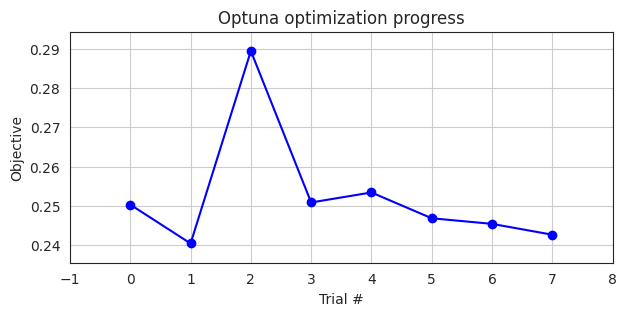

In [6]:
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-09-18 17:38:37,786] A new study created in RDB with name: no-name-79356e77-a9a8-4870-9e58-b60f00163c50



▶ Trial 0 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.13626787384035308, 'DROPOUT_LONG': 0.06693235970416676, 'ATT_DROPOUT': 0.31333116343680306, 'INITIAL_LR': 2.901300724822737e-05, 'ETA_MIN': 5.370967771887404e-06, 'WEIGHT_DECAY': 0.002317375143493553, 'CLIPNORM': 7.324156614347733}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['adx_14', 'atr_14', 'ret', 'atr_pct_14', 'log_ret', 'macd_signal_12_26_9', 'bb_hband_20', 'body', 'bb_w_20', 'eng_vwap', 'minus_di_14', 'body_pct', 'hour', 'eng_obv', 'vol_spike_14', 'macd_diff_12_26_9', 'sma_28', 'eng_sma_long', 'obv_pct_14', 'eng_macd']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


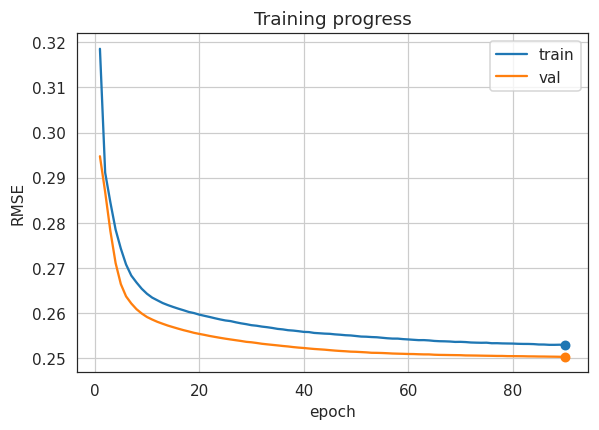

Epoch 1:   0%|          | 0/60 [00:05<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.3186 MAE=0.2731 R2=-0.2080 | "B": Acc=0.5419 Prec=0.3343 Rec=0.6863 F1=0.4496 AUROC=0.6225
VALID→ "R": RMSE=0.2947 MAE=0.2101 R2=-0.0692 | "B": Acc=0.6682 Prec=0.4283 Rec=0.5471 F1=0.4805 AUROC=0.6774


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2911 MAE=0.2225 R2=-0.0088 | "B": Acc=0.4966 Prec=0.3223 Rec=0.7675 F1=0.4540 AUROC=0.6264
VALID→ "R": RMSE=0.2868 MAE=0.2042 R2=-0.0125 | "B": Acc=0.5366 Prec=0.3546 Rec=0.7953 F1=0.4905 AUROC=0.6829


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2845 MAE=0.2171 R2=0.0365 | "B": Acc=0.4585 Prec=0.3162 Rec=0.8480 F1=0.4606 AUROC=0.6449
VALID→ "R": RMSE=0.2782 MAE=0.2009 R2=0.0477 | "B": Acc=0.5120 Prec=0.3460 Rec=0.8318 F1=0.4887 AUROC=0.6892


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2785 MAE=0.2153 R2=0.0768 | "B": Acc=0.4622 Prec=0.3195 Rec=0.8610 F1=0.4661 AUROC=0.6596
VALID→ "R": RMSE=0.2711 MAE=0.2002 R2=0.0957 | "B": Acc=0.5021 Prec=0.3429 Rec=0.8466 F1=0.4881 AUROC=0.6924


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2743 MAE=0.2137 R2=0.1045 | "B": Acc=0.4858 Prec=0.3282 Rec=0.8458 F1=0.4728 AUROC=0.6709
VALID→ "R": RMSE=0.2664 MAE=0.2010 R2=0.1265 | "B": Acc=0.5089 Prec=0.3458 Rec=0.8427 F1=0.4904 AUROC=0.6946


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2708 MAE=0.2104 R2=0.1274 | "B": Acc=0.5265 Prec=0.3434 Rec=0.8077 F1=0.4819 AUROC=0.6805
VALID→ "R": RMSE=0.2637 MAE=0.2025 R2=0.1442 | "B": Acc=0.5237 Prec=0.3519 Rec=0.8299 F1=0.4942 AUROC=0.6974


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2683 MAE=0.2078 R2=0.1432 | "B": Acc=0.5597 Prec=0.3574 Rec=0.7704 F1=0.4883 AUROC=0.6869
VALID→ "R": RMSE=0.2621 MAE=0.2012 R2=0.1544 | "B": Acc=0.5486 Prec=0.3627 Rec=0.8056 F1=0.5002 AUROC=0.7007
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26211_chp.pth


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2668 MAE=0.2059 R2=0.1529 | "B": Acc=0.5850 Prec=0.3694 Rec=0.7383 F1=0.4924 AUROC=0.6905
VALID→ "R": RMSE=0.2608 MAE=0.1999 R2=0.1626 | "B": Acc=0.5711 Prec=0.3735 Rec=0.7818 F1=0.5055 AUROC=0.7042
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26084_chp.pth


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2654 MAE=0.2047 R2=0.1617 | "B": Acc=0.6043 Prec=0.3798 Rec=0.7130 F1=0.4956 AUROC=0.6937
VALID→ "R": RMSE=0.2599 MAE=0.1978 R2=0.1687 | "B": Acc=0.5940 Prec=0.3858 Rec=0.7569 F1=0.5111 AUROC=0.7076
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25989_chp.pth


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2643 MAE=0.2035 R2=0.1687 | "B": Acc=0.6206 Prec=0.3894 Rec=0.6893 F1=0.4976 AUROC=0.6966
VALID→ "R": RMSE=0.2591 MAE=0.1962 R2=0.1737 | "B": Acc=0.6130 Prec=0.3974 Rec=0.7357 F1=0.5160 AUROC=0.7106
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25911_chp.pth


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2634 MAE=0.2027 R2=0.1741 | "B": Acc=0.6315 Prec=0.3966 Rec=0.6746 F1=0.4995 AUROC=0.6987
VALID→ "R": RMSE=0.2585 MAE=0.1950 R2=0.1773 | "B": Acc=0.6256 Prec=0.4058 Rec=0.7214 F1=0.5194 AUROC=0.7132
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25855_chp.pth


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2628 MAE=0.2022 R2=0.1779 | "B": Acc=0.6395 Prec=0.4021 Rec=0.6618 F1=0.5003 AUROC=0.7002
VALID→ "R": RMSE=0.2580 MAE=0.1941 R2=0.1805 | "B": Acc=0.6358 Prec=0.4130 Rec=0.7091 F1=0.5220 AUROC=0.7154
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25804_chp.pth


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2622 MAE=0.2016 R2=0.1816 | "B": Acc=0.6471 Prec=0.4077 Rec=0.6502 F1=0.5012 AUROC=0.7016
VALID→ "R": RMSE=0.2576 MAE=0.1935 R2=0.1832 | "B": Acc=0.6448 Prec=0.4197 Rec=0.6962 F1=0.5237 AUROC=0.7173
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25761_chp.pth


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2617 MAE=0.2011 R2=0.1845 | "B": Acc=0.6548 Prec=0.4135 Rec=0.6364 F1=0.5013 AUROC=0.7029
VALID→ "R": RMSE=0.2572 MAE=0.1930 R2=0.1858 | "B": Acc=0.6520 Prec=0.4252 Rec=0.6853 F1=0.5248 AUROC=0.7189
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25721_chp.pth


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2613 MAE=0.2004 R2=0.1870 | "B": Acc=0.6597 Prec=0.4173 Rec=0.6265 F1=0.5010 AUROC=0.7030
VALID→ "R": RMSE=0.2569 MAE=0.1925 R2=0.1880 | "B": Acc=0.6583 Prec=0.4303 Rec=0.6744 F1=0.5254 AUROC=0.7204
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25686_chp.pth


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2610 MAE=0.2000 R2=0.1894 | "B": Acc=0.6654 Prec=0.4222 Rec=0.6170 F1=0.5013 AUROC=0.7047
VALID→ "R": RMSE=0.2565 MAE=0.1921 R2=0.1901 | "B": Acc=0.6640 Prec=0.4351 Rec=0.6634 F1=0.5255 AUROC=0.7216
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25652_chp.pth


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2606 MAE=0.1996 R2=0.1916 | "B": Acc=0.6698 Prec=0.4261 Rec=0.6082 F1=0.5011 AUROC=0.7054
VALID→ "R": RMSE=0.2562 MAE=0.1918 R2=0.1922 | "B": Acc=0.6713 Prec=0.4415 Rec=0.6496 F1=0.5257 AUROC=0.7227
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25619_chp.pth


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2602 MAE=0.1993 R2=0.1939 | "B": Acc=0.6749 Prec=0.4306 Rec=0.5963 F1=0.5001 AUROC=0.7059
VALID→ "R": RMSE=0.2559 MAE=0.1915 R2=0.1940 | "B": Acc=0.6772 Prec=0.4471 Rec=0.6382 F1=0.5258 AUROC=0.7237
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25591_chp.pth


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2600 MAE=0.1990 R2=0.1954 | "B": Acc=0.6807 Prec=0.4360 Rec=0.5833 F1=0.4990 AUROC=0.7065
VALID→ "R": RMSE=0.2556 MAE=0.1913 R2=0.1959 | "B": Acc=0.6841 Prec=0.4540 Rec=0.6237 F1=0.5255 AUROC=0.7246
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25560_chp.pth


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2596 MAE=0.1987 R2=0.1976 | "B": Acc=0.6860 Prec=0.4413 Rec=0.5698 F1=0.4974 AUROC=0.7071
VALID→ "R": RMSE=0.2554 MAE=0.1909 R2=0.1974 | "B": Acc=0.6899 Prec=0.4600 Rec=0.6093 F1=0.5242 AUROC=0.7253
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25536_chp.pth


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2594 MAE=0.1984 R2=0.1992 | "B": Acc=0.6905 Prec=0.4458 Rec=0.5565 F1=0.4951 AUROC=0.7071
VALID→ "R": RMSE=0.2551 MAE=0.1907 R2=0.1988 | "B": Acc=0.6953 Prec=0.4661 Rec=0.5950 F1=0.5227 AUROC=0.7260
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25514_chp.pth


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2591 MAE=0.1982 R2=0.2008 | "B": Acc=0.6960 Prec=0.4522 Rec=0.5430 F1=0.4934 AUROC=0.7079
VALID→ "R": RMSE=0.2549 MAE=0.1905 R2=0.2003 | "B": Acc=0.7004 Prec=0.4723 Rec=0.5806 F1=0.5209 AUROC=0.7265
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25490_chp.pth


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2588 MAE=0.1979 R2=0.2025 | "B": Acc=0.7000 Prec=0.4568 Rec=0.5311 F1=0.4912 AUROC=0.7076
VALID→ "R": RMSE=0.2547 MAE=0.1903 R2=0.2016 | "B": Acc=0.7049 Prec=0.4780 Rec=0.5681 F1=0.5192 AUROC=0.7271
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25470_chp.pth


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2586 MAE=0.1977 R2=0.2041 | "B": Acc=0.7045 Prec=0.4625 Rec=0.5167 F1=0.4881 AUROC=0.7082
VALID→ "R": RMSE=0.2545 MAE=0.1901 R2=0.2028 | "B": Acc=0.7104 Prec=0.4856 Rec=0.5525 F1=0.5169 AUROC=0.7277
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25450_chp.pth


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2583 MAE=0.1976 R2=0.2055 | "B": Acc=0.7078 Prec=0.4669 Rec=0.5048 F1=0.4851 AUROC=0.7080
VALID→ "R": RMSE=0.2543 MAE=0.1899 R2=0.2040 | "B": Acc=0.7143 Prec=0.4914 Rec=0.5401 F1=0.5146 AUROC=0.7279
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25430_chp.pth


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2582 MAE=0.1974 R2=0.2064 | "B": Acc=0.7116 Prec=0.4723 Rec=0.4930 F1=0.4824 AUROC=0.7080
VALID→ "R": RMSE=0.2541 MAE=0.1897 R2=0.2051 | "B": Acc=0.7182 Prec=0.4977 Rec=0.5262 F1=0.5116 AUROC=0.7284
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25413_chp.pth


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2579 MAE=0.1972 R2=0.2081 | "B": Acc=0.7144 Prec=0.4766 Rec=0.4816 F1=0.4791 AUROC=0.7084
VALID→ "R": RMSE=0.2540 MAE=0.1896 R2=0.2062 | "B": Acc=0.7220 Prec=0.5042 Rec=0.5127 F1=0.5084 AUROC=0.7286
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25396_chp.pth


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2577 MAE=0.1970 R2=0.2095 | "B": Acc=0.7180 Prec=0.4823 Rec=0.4663 F1=0.4742 AUROC=0.7083
VALID→ "R": RMSE=0.2538 MAE=0.1894 R2=0.2072 | "B": Acc=0.7255 Prec=0.5107 Rec=0.4994 F1=0.5050 AUROC=0.7290
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25380_chp.pth


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2575 MAE=0.1969 R2=0.2106 | "B": Acc=0.7205 Prec=0.4866 Rec=0.4577 F1=0.4717 AUROC=0.7085
VALID→ "R": RMSE=0.2536 MAE=0.1893 R2=0.2084 | "B": Acc=0.7280 Prec=0.5158 Rec=0.4882 F1=0.5016 AUROC=0.7294
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25361_chp.pth


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2573 MAE=0.1966 R2=0.2120 | "B": Acc=0.7227 Prec=0.4907 Rec=0.4474 F1=0.4681 AUROC=0.7083
VALID→ "R": RMSE=0.2535 MAE=0.1891 R2=0.2090 | "B": Acc=0.7308 Prec=0.5220 Rec=0.4737 F1=0.4967 AUROC=0.7298
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25350_chp.pth


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2572 MAE=0.1965 R2=0.2127 | "B": Acc=0.7253 Prec=0.4957 Rec=0.4354 F1=0.4636 AUROC=0.7086
VALID→ "R": RMSE=0.2534 MAE=0.1890 R2=0.2100 | "B": Acc=0.7339 Prec=0.5296 Rec=0.4587 F1=0.4916 AUROC=0.7302
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25335_chp.pth


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2570 MAE=0.1964 R2=0.2139 | "B": Acc=0.7277 Prec=0.5009 Rec=0.4202 F1=0.4570 AUROC=0.7082
VALID→ "R": RMSE=0.2532 MAE=0.1889 R2=0.2111 | "B": Acc=0.7362 Prec=0.5358 Rec=0.4429 F1=0.4850 AUROC=0.7305
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25317_chp.pth


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2568 MAE=0.1962 R2=0.2147 | "B": Acc=0.7299 Prec=0.5058 Rec=0.4126 F1=0.4545 AUROC=0.7084
VALID→ "R": RMSE=0.2531 MAE=0.1887 R2=0.2119 | "B": Acc=0.7377 Prec=0.5405 Rec=0.4323 F1=0.4804 AUROC=0.7307
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25305_chp.pth


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2567 MAE=0.1961 R2=0.2158 | "B": Acc=0.7319 Prec=0.5106 Rec=0.4020 F1=0.4498 AUROC=0.7084
VALID→ "R": RMSE=0.2529 MAE=0.1886 R2=0.2126 | "B": Acc=0.7403 Prec=0.5492 Rec=0.4119 F1=0.4707 AUROC=0.7311
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25293_chp.pth


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2565 MAE=0.1959 R2=0.2170 | "B": Acc=0.7338 Prec=0.5156 Rec=0.3875 F1=0.4425 AUROC=0.7080
VALID→ "R": RMSE=0.2528 MAE=0.1885 R2=0.2133 | "B": Acc=0.7419 Prec=0.5553 Rec=0.3990 F1=0.4644 AUROC=0.7313
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25281_chp.pth


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2564 MAE=0.1958 R2=0.2177 | "B": Acc=0.7353 Prec=0.5201 Rec=0.3765 F1=0.4368 AUROC=0.7077
VALID→ "R": RMSE=0.2527 MAE=0.1885 R2=0.2141 | "B": Acc=0.7431 Prec=0.5605 Rec=0.3881 F1=0.4586 AUROC=0.7313
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25268_chp.pth


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2562 MAE=0.1956 R2=0.2188 | "B": Acc=0.7365 Prec=0.5240 Rec=0.3674 F1=0.4319 AUROC=0.7081
VALID→ "R": RMSE=0.2526 MAE=0.1884 R2=0.2148 | "B": Acc=0.7439 Prec=0.5653 Rec=0.3749 F1=0.4508 AUROC=0.7314
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25258_chp.pth


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2561 MAE=0.1955 R2=0.2193 | "B": Acc=0.7381 Prec=0.5293 Rec=0.3552 F1=0.4251 AUROC=0.7072
VALID→ "R": RMSE=0.2524 MAE=0.1883 R2=0.2157 | "B": Acc=0.7452 Prec=0.5724 Rec=0.3617 F1=0.4433 AUROC=0.7316
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25244_chp.pth


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2560 MAE=0.1953 R2=0.2201 | "B": Acc=0.7390 Prec=0.5328 Rec=0.3474 F1=0.4206 AUROC=0.7068
VALID→ "R": RMSE=0.2523 MAE=0.1882 R2=0.2164 | "B": Acc=0.7462 Prec=0.5784 Rec=0.3504 F1=0.4364 AUROC=0.7319
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25233_chp.pth


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2558 MAE=0.1951 R2=0.2210 | "B": Acc=0.7401 Prec=0.5369 Rec=0.3409 F1=0.4170 AUROC=0.7071
VALID→ "R": RMSE=0.2522 MAE=0.1881 R2=0.2169 | "B": Acc=0.7469 Prec=0.5838 Rec=0.3397 F1=0.4295 AUROC=0.7318
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25224_chp.pth


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2558 MAE=0.1950 R2=0.2213 | "B": Acc=0.7406 Prec=0.5395 Rec=0.3313 F1=0.4105 AUROC=0.7065
VALID→ "R": RMSE=0.2521 MAE=0.1880 R2=0.2176 | "B": Acc=0.7476 Prec=0.5893 Rec=0.3295 F1=0.4227 AUROC=0.7318
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25212_chp.pth


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2556 MAE=0.1949 R2=0.2225 | "B": Acc=0.7418 Prec=0.5445 Rec=0.3234 F1=0.4058 AUROC=0.7059
VALID→ "R": RMSE=0.2520 MAE=0.1879 R2=0.2183 | "B": Acc=0.7481 Prec=0.5965 Rec=0.3139 F1=0.4113 AUROC=0.7318
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25202_chp.pth


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2555 MAE=0.1947 R2=0.2229 | "B": Acc=0.7428 Prec=0.5502 Rec=0.3100 F1=0.3966 AUROC=0.7054
VALID→ "R": RMSE=0.2519 MAE=0.1879 R2=0.2187 | "B": Acc=0.7485 Prec=0.6029 Rec=0.3018 F1=0.4022 AUROC=0.7319
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25194_chp.pth


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2554 MAE=0.1946 R2=0.2234 | "B": Acc=0.7431 Prec=0.5528 Rec=0.3023 F1=0.3909 AUROC=0.7052
VALID→ "R": RMSE=0.2519 MAE=0.1878 R2=0.2192 | "B": Acc=0.7488 Prec=0.6095 Rec=0.2899 F1=0.3929 AUROC=0.7318
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25187_chp.pth


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2554 MAE=0.1945 R2=0.2237 | "B": Acc=0.7440 Prec=0.5581 Rec=0.2932 F1=0.3844 AUROC=0.7048
VALID→ "R": RMSE=0.2518 MAE=0.1878 R2=0.2199 | "B": Acc=0.7490 Prec=0.6167 Rec=0.2767 F1=0.3820 AUROC=0.7318
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25176_chp.pth


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2553 MAE=0.1943 R2=0.2244 | "B": Acc=0.7444 Prec=0.5611 Rec=0.2867 F1=0.3795 AUROC=0.7038
VALID→ "R": RMSE=0.2517 MAE=0.1878 R2=0.2205 | "B": Acc=0.7490 Prec=0.6211 Rec=0.2694 F1=0.3758 AUROC=0.7316
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25166_chp.pth


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2552 MAE=0.1942 R2=0.2249 | "B": Acc=0.7448 Prec=0.5644 Rec=0.2798 F1=0.3742 AUROC=0.7037
VALID→ "R": RMSE=0.2516 MAE=0.1877 R2=0.2210 | "B": Acc=0.7490 Prec=0.6276 Rec=0.2581 F1=0.3658 AUROC=0.7317
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25158_chp.pth


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2551 MAE=0.1942 R2=0.2256 | "B": Acc=0.7451 Prec=0.5672 Rec=0.2746 F1=0.3700 AUROC=0.7033
VALID→ "R": RMSE=0.2515 MAE=0.1876 R2=0.2214 | "B": Acc=0.7492 Prec=0.6352 Rec=0.2479 F1=0.3566 AUROC=0.7316
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25151_chp.pth


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2550 MAE=0.1941 R2=0.2259 | "B": Acc=0.7451 Prec=0.5687 Rec=0.2694 F1=0.3656 AUROC=0.7023
VALID→ "R": RMSE=0.2514 MAE=0.1876 R2=0.2219 | "B": Acc=0.7492 Prec=0.6392 Rec=0.2429 F1=0.3520 AUROC=0.7315
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25143_chp.pth


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2549 MAE=0.1940 R2=0.2266 | "B": Acc=0.7449 Prec=0.5685 Rec=0.2671 F1=0.3635 AUROC=0.7021
VALID→ "R": RMSE=0.2514 MAE=0.1875 R2=0.2221 | "B": Acc=0.7489 Prec=0.6460 Rec=0.2315 F1=0.3409 AUROC=0.7315
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25139_chp.pth


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2548 MAE=0.1939 R2=0.2274 | "B": Acc=0.7454 Prec=0.5729 Rec=0.2607 F1=0.3583 AUROC=0.7016
VALID→ "R": RMSE=0.2513 MAE=0.1875 R2=0.2225 | "B": Acc=0.7485 Prec=0.6512 Rec=0.2220 F1=0.3311 AUROC=0.7313
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25133_chp.pth


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2547 MAE=0.1939 R2=0.2276 | "B": Acc=0.7457 Prec=0.5764 Rec=0.2534 F1=0.3520 AUROC=0.7008
VALID→ "R": RMSE=0.2513 MAE=0.1874 R2=0.2229 | "B": Acc=0.7481 Prec=0.6559 Rec=0.2138 F1=0.3224 AUROC=0.7310
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25127_chp.pth


Epoch 53:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2547 MAE=0.1938 R2=0.2280 | "B": Acc=0.7461 Prec=0.5798 Rec=0.2499 F1=0.3493 AUROC=0.7009
VALID→ "R": RMSE=0.2512 MAE=0.1875 R2=0.2235 | "B": Acc=0.7478 Prec=0.6597 Rec=0.2078 F1=0.3160 AUROC=0.7310
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25118_chp.pth


Epoch 54:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2546 MAE=0.1938 R2=0.2283 | "B": Acc=0.7461 Prec=0.5824 Rec=0.2429 F1=0.3428 AUROC=0.6998
VALID→ "R": RMSE=0.2512 MAE=0.1874 R2=0.2236 | "B": Acc=0.7473 Prec=0.6676 Rec=0.1971 F1=0.3043 AUROC=0.7308
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25116_chp.pth


Epoch 55:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 055
TRAIN→ "R": RMSE=0.2545 MAE=0.1937 R2=0.2290 | "B": Acc=0.7463 Prec=0.5856 Rec=0.2376 F1=0.3380 AUROC=0.6990
VALID→ "R": RMSE=0.2511 MAE=0.1873 R2=0.2238 | "B": Acc=0.7470 Prec=0.6717 Rec=0.1909 F1=0.2973 AUROC=0.7304
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25113_chp.pth


Epoch 56:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 056
TRAIN→ "R": RMSE=0.2544 MAE=0.1936 R2=0.2296 | "B": Acc=0.7459 Prec=0.5852 Rec=0.2342 F1=0.3345 AUROC=0.6983
VALID→ "R": RMSE=0.2511 MAE=0.1873 R2=0.2241 | "B": Acc=0.7463 Prec=0.6767 Rec=0.1828 F1=0.2878 AUROC=0.7301
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25108_chp.pth


Epoch 57:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 057
TRAIN→ "R": RMSE=0.2543 MAE=0.1936 R2=0.2301 | "B": Acc=0.7460 Prec=0.5861 Rec=0.2325 F1=0.3329 AUROC=0.6980
VALID→ "R": RMSE=0.2510 MAE=0.1873 R2=0.2245 | "B": Acc=0.7459 Prec=0.6786 Rec=0.1785 F1=0.2827 AUROC=0.7300
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25101_chp.pth


Epoch 58:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 058
TRAIN→ "R": RMSE=0.2543 MAE=0.1935 R2=0.2301 | "B": Acc=0.7461 Prec=0.5886 Rec=0.2287 F1=0.3294 AUROC=0.6974
VALID→ "R": RMSE=0.2510 MAE=0.1873 R2=0.2247 | "B": Acc=0.7454 Prec=0.6830 Rec=0.1721 F1=0.2749 AUROC=0.7297
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25098_chp.pth


Epoch 59:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 059
TRAIN→ "R": RMSE=0.2542 MAE=0.1935 R2=0.2308 | "B": Acc=0.7462 Prec=0.5908 Rec=0.2248 F1=0.3257 AUROC=0.6977
VALID→ "R": RMSE=0.2509 MAE=0.1872 R2=0.2249 | "B": Acc=0.7448 Prec=0.6857 Rec=0.1659 F1=0.2671 AUROC=0.7294
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25095_chp.pth


Epoch 60:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 060
TRAIN→ "R": RMSE=0.2541 MAE=0.1934 R2=0.2312 | "B": Acc=0.7462 Prec=0.5918 Rec=0.2226 F1=0.3235 AUROC=0.6969
VALID→ "R": RMSE=0.2509 MAE=0.1872 R2=0.2251 | "B": Acc=0.7444 Prec=0.6873 Rec=0.1624 F1=0.2628 AUROC=0.7292
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25091_chp.pth


Epoch 61:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 061
TRAIN→ "R": RMSE=0.2541 MAE=0.1934 R2=0.2317 | "B": Acc=0.7464 Prec=0.5937 Rec=0.2213 F1=0.3225 AUROC=0.6969
VALID→ "R": RMSE=0.2509 MAE=0.1871 R2=0.2252 | "B": Acc=0.7439 Prec=0.6913 Rec=0.1567 F1=0.2555 AUROC=0.7289
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25090_chp.pth


Epoch 62:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 062
TRAIN→ "R": RMSE=0.2540 MAE=0.1933 R2=0.2322 | "B": Acc=0.7464 Prec=0.5957 Rec=0.2176 F1=0.3188 AUROC=0.6959
VALID→ "R": RMSE=0.2509 MAE=0.1871 R2=0.2255 | "B": Acc=0.7433 Prec=0.6958 Rec=0.1505 F1=0.2475 AUROC=0.7285
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25085_chp.pth


Epoch 63:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 063
TRAIN→ "R": RMSE=0.2540 MAE=0.1934 R2=0.2321 | "B": Acc=0.7464 Prec=0.5973 Rec=0.2141 F1=0.3153 AUROC=0.6952
VALID→ "R": RMSE=0.2508 MAE=0.1870 R2=0.2257 | "B": Acc=0.7427 Prec=0.6990 Rec=0.1448 F1=0.2399 AUROC=0.7281
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25082_chp.pth


Epoch 64:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 064
TRAIN→ "R": RMSE=0.2539 MAE=0.1933 R2=0.2325 | "B": Acc=0.7463 Prec=0.5987 Rec=0.2105 F1=0.3115 AUROC=0.6948
VALID→ "R": RMSE=0.2508 MAE=0.1869 R2=0.2257 | "B": Acc=0.7422 Prec=0.7009 Rec=0.1407 F1=0.2343 AUROC=0.7277
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25082_chp.pth


Epoch 65:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 065
TRAIN→ "R": RMSE=0.2538 MAE=0.1933 R2=0.2332 | "B": Acc=0.7464 Prec=0.6004 Rec=0.2088 F1=0.3099 AUROC=0.6945
VALID→ "R": RMSE=0.2507 MAE=0.1870 R2=0.2262 | "B": Acc=0.7419 Prec=0.7025 Rec=0.1378 F1=0.2304 AUROC=0.7273
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25074_chp.pth


Epoch 66:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 066
TRAIN→ "R": RMSE=0.2537 MAE=0.1932 R2=0.2336 | "B": Acc=0.7463 Prec=0.6009 Rec=0.2070 F1=0.3080 AUROC=0.6941
VALID→ "R": RMSE=0.2507 MAE=0.1870 R2=0.2264 | "B": Acc=0.7415 Prec=0.7059 Rec=0.1337 F1=0.2248 AUROC=0.7270
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25071_chp.pth


Epoch 67:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 067
TRAIN→ "R": RMSE=0.2537 MAE=0.1932 R2=0.2337 | "B": Acc=0.7461 Prec=0.6017 Rec=0.2036 F1=0.3043 AUROC=0.6933
VALID→ "R": RMSE=0.2507 MAE=0.1869 R2=0.2265 | "B": Acc=0.7410 Prec=0.7078 Rec=0.1303 F1=0.2201 AUROC=0.7265
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25069_chp.pth


Epoch 68:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 068
TRAIN→ "R": RMSE=0.2537 MAE=0.1932 R2=0.2340 | "B": Acc=0.7459 Prec=0.6019 Rec=0.2012 F1=0.3016 AUROC=0.6925
VALID→ "R": RMSE=0.2507 MAE=0.1869 R2=0.2266 | "B": Acc=0.7407 Prec=0.7093 Rec=0.1279 F1=0.2167 AUROC=0.7258
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25067_chp.pth


Epoch 69:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 069
TRAIN→ "R": RMSE=0.2536 MAE=0.1932 R2=0.2345 | "B": Acc=0.7461 Prec=0.6031 Rec=0.2011 F1=0.3017 AUROC=0.6920
VALID→ "R": RMSE=0.2507 MAE=0.1868 R2=0.2267 | "B": Acc=0.7404 Prec=0.7112 Rec=0.1253 F1=0.2130 AUROC=0.7255
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25066_chp.pth


Epoch 70:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 070
TRAIN→ "R": RMSE=0.2536 MAE=0.1931 R2=0.2344 | "B": Acc=0.7459 Prec=0.6032 Rec=0.1987 F1=0.2989 AUROC=0.6917
VALID→ "R": RMSE=0.2506 MAE=0.1868 R2=0.2268 | "B": Acc=0.7397 Prec=0.7126 Rec=0.1205 F1=0.2061 AUROC=0.7251
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25064_chp.pth


Epoch 71:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 071
TRAIN→ "R": RMSE=0.2536 MAE=0.1931 R2=0.2348 | "B": Acc=0.7459 Prec=0.6051 Rec=0.1959 F1=0.2960 AUROC=0.6913
VALID→ "R": RMSE=0.2506 MAE=0.1869 R2=0.2271 | "B": Acc=0.7395 Prec=0.7148 Rec=0.1184 F1=0.2032 AUROC=0.7250
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25059_chp.pth


Epoch 72:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 072
TRAIN→ "R": RMSE=0.2535 MAE=0.1931 R2=0.2353 | "B": Acc=0.7459 Prec=0.6069 Rec=0.1936 F1=0.2935 AUROC=0.6910
VALID→ "R": RMSE=0.2506 MAE=0.1868 R2=0.2272 | "B": Acc=0.7392 Prec=0.7175 Rec=0.1152 F1=0.1985 AUROC=0.7246
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25058_chp.pth


Epoch 73:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 073
TRAIN→ "R": RMSE=0.2534 MAE=0.1930 R2=0.2355 | "B": Acc=0.7462 Prec=0.6094 Rec=0.1921 F1=0.2921 AUROC=0.6903
VALID→ "R": RMSE=0.2506 MAE=0.1868 R2=0.2273 | "B": Acc=0.7389 Prec=0.7195 Rec=0.1128 F1=0.1950 AUROC=0.7244
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25056_chp.pth


Epoch 74:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 074
TRAIN→ "R": RMSE=0.2534 MAE=0.1930 R2=0.2357 | "B": Acc=0.7458 Prec=0.6080 Rec=0.1904 F1=0.2900 AUROC=0.6904
VALID→ "R": RMSE=0.2505 MAE=0.1867 R2=0.2274 | "B": Acc=0.7386 Prec=0.7204 Rec=0.1108 F1=0.1920 AUROC=0.7239
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25054_chp.pth


Epoch 75:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 075
TRAIN→ "R": RMSE=0.2534 MAE=0.1930 R2=0.2356 | "B": Acc=0.7457 Prec=0.6079 Rec=0.1895 F1=0.2889 AUROC=0.6894
VALID→ "R": RMSE=0.2505 MAE=0.1868 R2=0.2276 | "B": Acc=0.7383 Prec=0.7217 Rec=0.1085 F1=0.1886 AUROC=0.7236
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25052_chp.pth


Epoch 76:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 076
TRAIN→ "R": RMSE=0.2533 MAE=0.1930 R2=0.2363 | "B": Acc=0.7456 Prec=0.6084 Rec=0.1877 F1=0.2869 AUROC=0.6892
VALID→ "R": RMSE=0.2505 MAE=0.1867 R2=0.2277 | "B": Acc=0.7380 Prec=0.7234 Rec=0.1062 F1=0.1852 AUROC=0.7231
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25050_chp.pth


Epoch 77:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 077
TRAIN→ "R": RMSE=0.2533 MAE=0.1930 R2=0.2363 | "B": Acc=0.7458 Prec=0.6106 Rec=0.1871 F1=0.2865 AUROC=0.6889
VALID→ "R": RMSE=0.2505 MAE=0.1867 R2=0.2278 | "B": Acc=0.7378 Prec=0.7247 Rec=0.1049 F1=0.1833 AUROC=0.7229
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25048_chp.pth


Epoch 78:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 078
TRAIN→ "R": RMSE=0.2533 MAE=0.1929 R2=0.2365 | "B": Acc=0.7457 Prec=0.6101 Rec=0.1869 F1=0.2861 AUROC=0.6883
VALID→ "R": RMSE=0.2505 MAE=0.1866 R2=0.2278 | "B": Acc=0.7377 Prec=0.7256 Rec=0.1038 F1=0.1816 AUROC=0.7225
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25048_chp.pth


Epoch 79:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 079
TRAIN→ "R": RMSE=0.2532 MAE=0.1929 R2=0.2366 | "B": Acc=0.7455 Prec=0.6093 Rec=0.1856 F1=0.2845 AUROC=0.6881
VALID→ "R": RMSE=0.2504 MAE=0.1867 R2=0.2281 | "B": Acc=0.7375 Prec=0.7269 Rec=0.1025 F1=0.1796 AUROC=0.7222
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25044_chp.pth


Epoch 80:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 080
TRAIN→ "R": RMSE=0.2532 MAE=0.1929 R2=0.2368 | "B": Acc=0.7454 Prec=0.6087 Rec=0.1854 F1=0.2842 AUROC=0.6881
VALID→ "R": RMSE=0.2504 MAE=0.1866 R2=0.2281 | "B": Acc=0.7374 Prec=0.7272 Rec=0.1015 F1=0.1781 AUROC=0.7221
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25043_chp.pth


Epoch 81:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 081
TRAIN→ "R": RMSE=0.2532 MAE=0.1929 R2=0.2371 | "B": Acc=0.7453 Prec=0.6084 Rec=0.1852 F1=0.2839 AUROC=0.6873
VALID→ "R": RMSE=0.2504 MAE=0.1866 R2=0.2282 | "B": Acc=0.7372 Prec=0.7274 Rec=0.1002 F1=0.1762 AUROC=0.7217
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25042_chp.pth


Epoch 82:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 082
TRAIN→ "R": RMSE=0.2531 MAE=0.1929 R2=0.2372 | "B": Acc=0.7453 Prec=0.6089 Rec=0.1845 F1=0.2832 AUROC=0.6870
VALID→ "R": RMSE=0.2504 MAE=0.1866 R2=0.2282 | "B": Acc=0.7369 Prec=0.7289 Rec=0.0982 F1=0.1731 AUROC=0.7212
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25041_chp.pth


Epoch 83:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 083
TRAIN→ "R": RMSE=0.2531 MAE=0.1929 R2=0.2373 | "B": Acc=0.7455 Prec=0.6101 Rec=0.1842 F1=0.2830 AUROC=0.6868
VALID→ "R": RMSE=0.2504 MAE=0.1866 R2=0.2284 | "B": Acc=0.7366 Prec=0.7293 Rec=0.0964 F1=0.1703 AUROC=0.7209
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25038_chp.pth


Epoch 84:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 084
TRAIN→ "R": RMSE=0.2531 MAE=0.1928 R2=0.2375 | "B": Acc=0.7452 Prec=0.6096 Rec=0.1826 F1=0.2810 AUROC=0.6864
VALID→ "R": RMSE=0.2504 MAE=0.1866 R2=0.2285 | "B": Acc=0.7363 Prec=0.7304 Rec=0.0948 F1=0.1678 AUROC=0.7203
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25037_chp.pth


Epoch 85:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 085
TRAIN→ "R": RMSE=0.2530 MAE=0.1928 R2=0.2380 | "B": Acc=0.7452 Prec=0.6095 Rec=0.1817 F1=0.2799 AUROC=0.6864
VALID→ "R": RMSE=0.2504 MAE=0.1866 R2=0.2286 | "B": Acc=0.7361 Prec=0.7310 Rec=0.0934 F1=0.1657 AUROC=0.7198
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25035_chp.pth


Epoch 86:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 086
TRAIN→ "R": RMSE=0.2530 MAE=0.1928 R2=0.2380 | "B": Acc=0.7453 Prec=0.6111 Rec=0.1813 F1=0.2796 AUROC=0.6851
VALID→ "R": RMSE=0.2503 MAE=0.1865 R2=0.2286 | "B": Acc=0.7359 Prec=0.7320 Rec=0.0917 F1=0.1630 AUROC=0.7194
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25034_chp.pth


Epoch 87:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 087
TRAIN→ "R": RMSE=0.2529 MAE=0.1928 R2=0.2384 | "B": Acc=0.7455 Prec=0.6130 Rec=0.1803 F1=0.2786 AUROC=0.6857
VALID→ "R": RMSE=0.2503 MAE=0.1866 R2=0.2288 | "B": Acc=0.7357 Prec=0.7326 Rec=0.0904 F1=0.1610 AUROC=0.7190
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25032_chp.pth


Epoch 88:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 088
TRAIN→ "R": RMSE=0.2529 MAE=0.1927 R2=0.2384 | "B": Acc=0.7452 Prec=0.6125 Rec=0.1783 F1=0.2762 AUROC=0.6849
VALID→ "R": RMSE=0.2503 MAE=0.1865 R2=0.2288 | "B": Acc=0.7354 Prec=0.7327 Rec=0.0891 F1=0.1589 AUROC=0.7187
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25031_chp.pth


Epoch 89:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 089
TRAIN→ "R": RMSE=0.2530 MAE=0.1928 R2=0.2383 | "B": Acc=0.7449 Prec=0.6108 Rec=0.1773 F1=0.2749 AUROC=0.6844
VALID→ "R": RMSE=0.2503 MAE=0.1865 R2=0.2290 | "B": Acc=0.7354 Prec=0.7331 Rec=0.0886 F1=0.1580 AUROC=0.7183
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25029_chp.pth


Epoch 90:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 090
TRAIN→ "R": RMSE=0.2529 MAE=0.1927 R2=0.2388 | "B": Acc=0.7449 Prec=0.6113 Rec=0.1767 F1=0.2742 AUROC=0.6844
VALID→ "R": RMSE=0.2503 MAE=0.1865 R2=0.2290 | "B": Acc=0.7352 Prec=0.7339 Rec=0.0877 F1=0.1566 AUROC=0.7180
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25029_chp.pth
✅ Final best model (_fin) saved: AAPL_0.25029_fin.pth
Delete variables to free memory...


[I 2025-09-18 19:12:33,520] Trial 0 finished with value: 0.25028756260871887 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.13626787384035308, 'DROPOUT_LONG': 0.06693235970416676, 'ATT_DROPOUT': 0.31333116343680306, 'INITIAL_LR': 2.901300724822737e-05, 'ETA_MIN': 5.370967771887404e-06, 'WEIGHT_DECAY': 0.002317375143493553, 'CLIPNORM': 7.324156614347733}. Best is trial 0 with value: 0.25028756260871887.



▶ Trial 1 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.13086041365374274, 'DROPOUT_LONG': 0.16965873863642492, 'ATT_DROPOUT': 0.07573988360973218, 'INITIAL_LR': 0.00038936908999260997, 'ETA_MIN': 6.706829819819508e-06, 'WEIGHT_DECAY': 0.006118864071633351, 'CLIPNORM': 0.5348697391669399}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['adx_14', 'atr_14', 'ret', 'atr_pct_14', 'log_ret', 'macd_signal_12_26_9', 'bb_hband_20', 'body', 'bb_w_20', 'eng_vwap', 'minus_di_14', 'body_pct', 'hour', 'eng_obv', 'vol_spike_14', 'macd_diff_12_26_9', 'sma_28', 'eng_sma_long', 'obv_pct_14', 'eng_macd']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


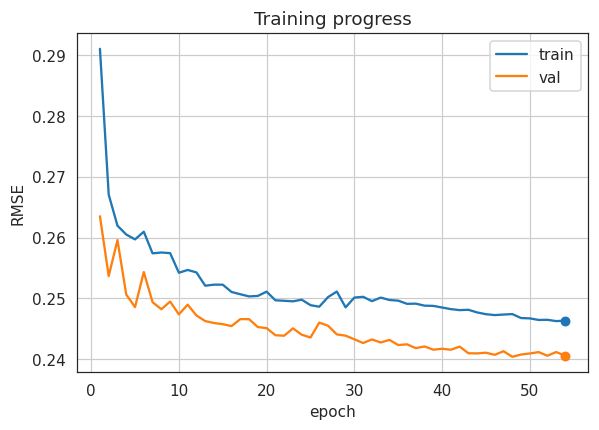

Epoch 1:   0%|          | 0/60 [00:01<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2910 MAE=0.2277 R2=-0.0082 | "B": Acc=0.7067 Prec=0.1896 Rec=0.0232 F1=0.0413 AUROC=0.4666
VALID→ "R": RMSE=0.2635 MAE=0.2040 R2=0.1455 | "B": Acc=0.6675 Prec=0.1737 Rec=0.0495 F1=0.0770 AUROC=0.4089


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2671 MAE=0.2060 R2=0.1511 | "B": Acc=0.6384 Prec=0.1934 Rec=0.1029 F1=0.1344 AUROC=0.4223
VALID→ "R": RMSE=0.2537 MAE=0.1914 R2=0.2080 | "B": Acc=0.6830 Prec=0.1306 Rec=0.0230 F1=0.0392 AUROC=0.3782


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2619 MAE=0.2015 R2=0.1832 | "B": Acc=0.6240 Prec=0.1837 Rec=0.1100 F1=0.1376 AUROC=0.4071
VALID→ "R": RMSE=0.2596 MAE=0.1818 R2=0.1706 | "B": Acc=0.5072 Prec=0.1844 Rec=0.2213 F1=0.2012 AUROC=0.3612


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2605 MAE=0.2004 R2=0.1923 | "B": Acc=0.5805 Prec=0.2025 Rec=0.1833 F1=0.1924 AUROC=0.4144
VALID→ "R": RMSE=0.2506 MAE=0.1960 R2=0.2269 | "B": Acc=0.5506 Prec=0.1524 Rec=0.1322 F1=0.1416 AUROC=0.3278


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2597 MAE=0.1992 R2=0.1972 | "B": Acc=0.5712 Prec=0.1903 Rec=0.1760 F1=0.1829 AUROC=0.3940
VALID→ "R": RMSE=0.2486 MAE=0.1895 R2=0.2396 | "B": Acc=0.5175 Prec=0.1680 Rec=0.1823 F1=0.1748 AUROC=0.3431
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24856_chp.pth


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2610 MAE=0.1991 R2=0.1894 | "B": Acc=0.5550 Prec=0.1922 Rec=0.1973 F1=0.1947 AUROC=0.3900
VALID→ "R": RMSE=0.2543 MAE=0.1803 R2=0.2039 | "B": Acc=0.4414 Prec=0.1713 Rec=0.2585 F1=0.2061 AUROC=0.3253


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2574 MAE=0.1971 R2=0.2113 | "B": Acc=0.5493 Prec=0.1842 Rec=0.1904 F1=0.1872 AUROC=0.3744
VALID→ "R": RMSE=0.2494 MAE=0.1958 R2=0.2346 | "B": Acc=0.3947 Prec=0.2005 Rec=0.3879 F1=0.2644 AUROC=0.3438


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2575 MAE=0.1956 R2=0.2105 | "B": Acc=0.5249 Prec=0.2032 Rec=0.2541 F1=0.2258 AUROC=0.3935
VALID→ "R": RMSE=0.2482 MAE=0.1854 R2=0.2417 | "B": Acc=0.3471 Prec=0.2075 Rec=0.4713 F1=0.2882 AUROC=0.3368
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24821_chp.pth


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2574 MAE=0.1975 R2=0.2111 | "B": Acc=0.5155 Prec=0.1905 Rec=0.2392 F1=0.2121 AUROC=0.3751
VALID→ "R": RMSE=0.2495 MAE=0.1962 R2=0.2340 | "B": Acc=0.3137 Prec=0.2084 Rec=0.5172 F1=0.2971 AUROC=0.3173


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2542 MAE=0.1939 R2=0.2307 | "B": Acc=0.4818 Prec=0.1971 Rec=0.2931 F1=0.2357 AUROC=0.3746
VALID→ "R": RMSE=0.2474 MAE=0.1925 R2=0.2469 | "B": Acc=0.3211 Prec=0.2034 Rec=0.4872 F1=0.2870 AUROC=0.3124
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24737_chp.pth


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2547 MAE=0.1931 R2=0.2280 | "B": Acc=0.4581 Prec=0.2016 Rec=0.3336 F1=0.2514 AUROC=0.3756
VALID→ "R": RMSE=0.2490 MAE=0.1935 R2=0.2371 | "B": Acc=0.2999 Prec=0.2029 Rec=0.5112 F1=0.2905 AUROC=0.3027


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2543 MAE=0.1938 R2=0.2304 | "B": Acc=0.4547 Prec=0.1923 Rec=0.3125 F1=0.2381 AUROC=0.3614
VALID→ "R": RMSE=0.2472 MAE=0.1912 R2=0.2480 | "B": Acc=0.2640 Prec=0.2254 Rec=0.6666 F1=0.3369 AUROC=0.2978
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24718_chp.pth


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2521 MAE=0.1916 R2=0.2436 | "B": Acc=0.4078 Prec=0.1991 Rec=0.3876 F1=0.2630 AUROC=0.3570
VALID→ "R": RMSE=0.2463 MAE=0.1828 R2=0.2536 | "B": Acc=0.2623 Prec=0.2353 Rec=0.7245 F1=0.3552 AUROC=0.3020
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24626_chp.pth


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2523 MAE=0.1911 R2=0.2426 | "B": Acc=0.3976 Prec=0.2055 Rec=0.4218 F1=0.2763 AUROC=0.3637
VALID→ "R": RMSE=0.2459 MAE=0.1915 R2=0.2555 | "B": Acc=0.2596 Prec=0.2288 Rec=0.6917 F1=0.3438 AUROC=0.2868
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24595_chp.pth


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2522 MAE=0.1908 R2=0.2426 | "B": Acc=0.4017 Prec=0.1994 Rec=0.3962 F1=0.2653 AUROC=0.3569
VALID→ "R": RMSE=0.2458 MAE=0.1893 R2=0.2566 | "B": Acc=0.2813 Prec=0.2018 Rec=0.5289 F1=0.2921 AUROC=0.2988
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24576_chp.pth


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2511 MAE=0.1916 R2=0.2498 | "B": Acc=0.4201 Prec=0.1897 Rec=0.3446 F1=0.2447 AUROC=0.3479
VALID→ "R": RMSE=0.2454 MAE=0.1824 R2=0.2586 | "B": Acc=0.2592 Prec=0.2224 Rec=0.6575 F1=0.3324 AUROC=0.2937
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24544_chp.pth


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2507 MAE=0.1902 R2=0.2520 | "B": Acc=0.4055 Prec=0.1920 Rec=0.3681 F1=0.2524 AUROC=0.3466
VALID→ "R": RMSE=0.2466 MAE=0.1806 R2=0.2516 | "B": Acc=0.2712 Prec=0.1987 Rec=0.5272 F1=0.2886 AUROC=0.2891


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2503 MAE=0.1901 R2=0.2541 | "B": Acc=0.4025 Prec=0.1923 Rec=0.3723 F1=0.2536 AUROC=0.3468
VALID→ "R": RMSE=0.2466 MAE=0.1797 R2=0.2517 | "B": Acc=0.2604 Prec=0.2097 Rec=0.5915 F1=0.3097 AUROC=0.2932


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2504 MAE=0.1899 R2=0.2536 | "B": Acc=0.3912 Prec=0.1949 Rec=0.3937 F1=0.2607 AUROC=0.3471
VALID→ "R": RMSE=0.2453 MAE=0.1926 R2=0.2595 | "B": Acc=0.2891 Prec=0.1823 Rec=0.4403 F1=0.2578 AUROC=0.2867
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24528_chp.pth


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2511 MAE=0.1915 R2=0.2495 | "B": Acc=0.4098 Prec=0.1867 Rec=0.3469 F1=0.2427 AUROC=0.3408
VALID→ "R": RMSE=0.2451 MAE=0.1919 R2=0.2606 | "B": Acc=0.2914 Prec=0.1921 Rec=0.4763 F1=0.2738 AUROC=0.3003
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24510_chp.pth


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2497 MAE=0.1903 R2=0.2579 | "B": Acc=0.4085 Prec=0.1892 Rec=0.3559 F1=0.2471 AUROC=0.3452
VALID→ "R": RMSE=0.2439 MAE=0.1836 R2=0.2676 | "B": Acc=0.2643 Prec=0.2041 Rec=0.5599 F1=0.2991 AUROC=0.2944
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24394_chp.pth


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2496 MAE=0.1892 R2=0.2584 | "B": Acc=0.3794 Prec=0.1885 Rec=0.3862 F1=0.2533 AUROC=0.3348
VALID→ "R": RMSE=0.2439 MAE=0.1867 R2=0.2681 | "B": Acc=0.2730 Prec=0.1962 Rec=0.5142 F1=0.2840 AUROC=0.2958
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24385_chp.pth


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2495 MAE=0.1882 R2=0.2589 | "B": Acc=0.3761 Prec=0.1948 Rec=0.4112 F1=0.2644 AUROC=0.3440
VALID→ "R": RMSE=0.2451 MAE=0.1913 R2=0.2608 | "B": Acc=0.3088 Prec=0.1784 Rec=0.4062 F1=0.2479 AUROC=0.2967


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2498 MAE=0.1905 R2=0.2573 | "B": Acc=0.4017 Prec=0.1843 Rec=0.3487 F1=0.2412 AUROC=0.3359
VALID→ "R": RMSE=0.2440 MAE=0.1841 R2=0.2671 | "B": Acc=0.2684 Prec=0.1996 Rec=0.5344 F1=0.2906 AUROC=0.2972


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2489 MAE=0.1883 R2=0.2627 | "B": Acc=0.3815 Prec=0.1881 Rec=0.3826 F1=0.2522 AUROC=0.3359
VALID→ "R": RMSE=0.2436 MAE=0.1877 R2=0.2698 | "B": Acc=0.2876 Prec=0.1861 Rec=0.4568 F1=0.2645 AUROC=0.2959
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24357_chp.pth


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2486 MAE=0.1884 R2=0.2642 | "B": Acc=0.3847 Prec=0.1878 Rec=0.3780 F1=0.2509 AUROC=0.3369
VALID→ "R": RMSE=0.2460 MAE=0.1946 R2=0.2551 | "B": Acc=0.3047 Prec=0.1775 Rec=0.4070 F1=0.2472 AUROC=0.2921


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2502 MAE=0.1910 R2=0.2548 | "B": Acc=0.3987 Prec=0.1927 Rec=0.3781 F1=0.2553 AUROC=0.3480
VALID→ "R": RMSE=0.2455 MAE=0.1794 R2=0.2582 | "B": Acc=0.2667 Prec=0.2053 Rec=0.5623 F1=0.3007 AUROC=0.3067


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2511 MAE=0.1915 R2=0.2494 | "B": Acc=0.4018 Prec=0.1805 Rec=0.3372 F1=0.2351 AUROC=0.3319
VALID→ "R": RMSE=0.2441 MAE=0.1887 R2=0.2668 | "B": Acc=0.2831 Prec=0.1891 Rec=0.4734 F1=0.2703 AUROC=0.2860


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2485 MAE=0.1882 R2=0.2648 | "B": Acc=0.3916 Prec=0.1799 Rec=0.3460 F1=0.2367 AUROC=0.3280
VALID→ "R": RMSE=0.2439 MAE=0.1886 R2=0.2680 | "B": Acc=0.3001 Prec=0.1779 Rec=0.4132 F1=0.2487 AUROC=0.2846


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2501 MAE=0.1908 R2=0.2553 | "B": Acc=0.3891 Prec=0.1824 Rec=0.3561 F1=0.2412 AUROC=0.3317
VALID→ "R": RMSE=0.2433 MAE=0.1817 R2=0.2716 | "B": Acc=0.2836 Prec=0.1892 Rec=0.4733 F1=0.2703 AUROC=0.2986
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24327_chp.pth


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2503 MAE=0.1903 R2=0.2545 | "B": Acc=0.4219 Prec=0.1794 Rec=0.3135 F1=0.2282 AUROC=0.3371
VALID→ "R": RMSE=0.2427 MAE=0.1824 R2=0.2753 | "B": Acc=0.2877 Prec=0.1867 Rec=0.4590 F1=0.2654 AUROC=0.2973
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24266_chp.pth


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2495 MAE=0.1901 R2=0.2588 | "B": Acc=0.4200 Prec=0.1785 Rec=0.3129 F1=0.2273 AUROC=0.3355
VALID→ "R": RMSE=0.2432 MAE=0.1815 R2=0.2718 | "B": Acc=0.2811 Prec=0.1932 Rec=0.4925 F1=0.2775 AUROC=0.3054


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2501 MAE=0.1903 R2=0.2553 | "B": Acc=0.4125 Prec=0.1811 Rec=0.3280 F1=0.2334 AUROC=0.3373
VALID→ "R": RMSE=0.2427 MAE=0.1804 R2=0.2747 | "B": Acc=0.2754 Prec=0.1962 Rec=0.5116 F1=0.2837 AUROC=0.3042


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2497 MAE=0.1895 R2=0.2576 | "B": Acc=0.4092 Prec=0.1808 Rec=0.3303 F1=0.2337 AUROC=0.3360
VALID→ "R": RMSE=0.2432 MAE=0.1800 R2=0.2722 | "B": Acc=0.2743 Prec=0.1980 Rec=0.5206 F1=0.2869 AUROC=0.3041


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2496 MAE=0.1897 R2=0.2583 | "B": Acc=0.4166 Prec=0.1818 Rec=0.3255 F1=0.2332 AUROC=0.3391
VALID→ "R": RMSE=0.2423 MAE=0.1804 R2=0.2773 | "B": Acc=0.2826 Prec=0.1940 Rec=0.4940 F1=0.2786 AUROC=0.3055
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24233_chp.pth


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2491 MAE=0.1887 R2=0.2614 | "B": Acc=0.4061 Prec=0.1829 Rec=0.3397 F1=0.2378 AUROC=0.3381
VALID→ "R": RMSE=0.2424 MAE=0.1818 R2=0.2766 | "B": Acc=0.2780 Prec=0.1967 Rec=0.5107 F1=0.2840 AUROC=0.3048


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2491 MAE=0.1892 R2=0.2612 | "B": Acc=0.4112 Prec=0.1829 Rec=0.3345 F1=0.2365 AUROC=0.3406
VALID→ "R": RMSE=0.2418 MAE=0.1799 R2=0.2803 | "B": Acc=0.2832 Prec=0.1957 Rec=0.5002 F1=0.2813 AUROC=0.3085
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24182_chp.pth


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2488 MAE=0.1885 R2=0.2631 | "B": Acc=0.4154 Prec=0.1818 Rec=0.3269 F1=0.2336 AUROC=0.3404
VALID→ "R": RMSE=0.2421 MAE=0.1806 R2=0.2786 | "B": Acc=0.2767 Prec=0.1984 Rec=0.5195 F1=0.2872 AUROC=0.3063


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2488 MAE=0.1886 R2=0.2634 | "B": Acc=0.4111 Prec=0.1837 Rec=0.3369 F1=0.2378 AUROC=0.3419
VALID→ "R": RMSE=0.2416 MAE=0.1804 R2=0.2818 | "B": Acc=0.2875 Prec=0.1947 Rec=0.4912 F1=0.2789 AUROC=0.3084
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24156_chp.pth


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2485 MAE=0.1882 R2=0.2650 | "B": Acc=0.4217 Prec=0.1844 Rec=0.3274 F1=0.2359 AUROC=0.3455
VALID→ "R": RMSE=0.2417 MAE=0.1809 R2=0.2809 | "B": Acc=0.2850 Prec=0.1950 Rec=0.4953 F1=0.2798 AUROC=0.3057


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2482 MAE=0.1881 R2=0.2665 | "B": Acc=0.4085 Prec=0.1838 Rec=0.3399 F1=0.2386 AUROC=0.3418
VALID→ "R": RMSE=0.2416 MAE=0.1809 R2=0.2818 | "B": Acc=0.2870 Prec=0.1965 Rec=0.4995 F1=0.2821 AUROC=0.3096
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24156_chp.pth


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2481 MAE=0.1875 R2=0.2675 | "B": Acc=0.4072 Prec=0.1854 Rec=0.3461 F1=0.2415 AUROC=0.3438
VALID→ "R": RMSE=0.2421 MAE=0.1791 R2=0.2788 | "B": Acc=0.2841 Prec=0.2001 Rec=0.5179 F1=0.2886 AUROC=0.3127


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2481 MAE=0.1869 R2=0.2672 | "B": Acc=0.4064 Prec=0.1855 Rec=0.3471 F1=0.2418 AUROC=0.3434
VALID→ "R": RMSE=0.2410 MAE=0.1810 R2=0.2853 | "B": Acc=0.2925 Prec=0.1923 Rec=0.4759 F1=0.2739 AUROC=0.3046
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24098_chp.pth


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2477 MAE=0.1886 R2=0.2698 | "B": Acc=0.4093 Prec=0.1830 Rec=0.3368 F1=0.2372 AUROC=0.3412
VALID→ "R": RMSE=0.2410 MAE=0.1788 R2=0.2854 | "B": Acc=0.2884 Prec=0.1939 Rec=0.4872 F1=0.2774 AUROC=0.3030
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24095_chp.pth


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2474 MAE=0.1876 R2=0.2715 | "B": Acc=0.4178 Prec=0.1801 Rec=0.3197 F1=0.2304 AUROC=0.3400
VALID→ "R": RMSE=0.2411 MAE=0.1794 R2=0.2848 | "B": Acc=0.2913 Prec=0.1940 Rec=0.4840 F1=0.2769 AUROC=0.3049


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2473 MAE=0.1867 R2=0.2723 | "B": Acc=0.4134 Prec=0.1817 Rec=0.3287 F1=0.2341 AUROC=0.3414
VALID→ "R": RMSE=0.2407 MAE=0.1807 R2=0.2868 | "B": Acc=0.2944 Prec=0.1921 Rec=0.4731 F1=0.2733 AUROC=0.3039
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24072_chp.pth


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2473 MAE=0.1880 R2=0.2718 | "B": Acc=0.4069 Prec=0.1795 Rec=0.3292 F1=0.2324 AUROC=0.3367
VALID→ "R": RMSE=0.2413 MAE=0.1778 R2=0.2833 | "B": Acc=0.2951 Prec=0.1866 Rec=0.4504 F1=0.2638 AUROC=0.2984


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2474 MAE=0.1868 R2=0.2713 | "B": Acc=0.4217 Prec=0.1765 Rec=0.3057 F1=0.2238 AUROC=0.3363
VALID→ "R": RMSE=0.2404 MAE=0.1813 R2=0.2887 | "B": Acc=0.3045 Prec=0.1825 Rec=0.4254 F1=0.2554 AUROC=0.2966
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24039_chp.pth


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2468 MAE=0.1877 R2=0.2752 | "B": Acc=0.4084 Prec=0.1795 Rec=0.3275 F1=0.2319 AUROC=0.3363
VALID→ "R": RMSE=0.2408 MAE=0.1785 R2=0.2865 | "B": Acc=0.2968 Prec=0.1873 Rec=0.4516 F1=0.2648 AUROC=0.2965


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2467 MAE=0.1865 R2=0.2755 | "B": Acc=0.4096 Prec=0.1801 Rec=0.3280 F1=0.2325 AUROC=0.3378
VALID→ "R": RMSE=0.2409 MAE=0.1784 R2=0.2855 | "B": Acc=0.2871 Prec=0.1937 Rec=0.4876 F1=0.2772 AUROC=0.2993


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2465 MAE=0.1867 R2=0.2770 | "B": Acc=0.4020 Prec=0.1805 Rec=0.3370 F1=0.2350 AUROC=0.3368
VALID→ "R": RMSE=0.2412 MAE=0.1783 R2=0.2842 | "B": Acc=0.2935 Prec=0.1890 Rec=0.4618 F1=0.2683 AUROC=0.2975


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2465 MAE=0.1860 R2=0.2769 | "B": Acc=0.4009 Prec=0.1794 Rec=0.3350 F1=0.2337 AUROC=0.3345
VALID→ "R": RMSE=0.2406 MAE=0.1795 R2=0.2877 | "B": Acc=0.3002 Prec=0.1873 Rec=0.4481 F1=0.2642 AUROC=0.3001


Epoch 53:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2463 MAE=0.1867 R2=0.2781 | "B": Acc=0.3991 Prec=0.1822 Rec=0.3450 F1=0.2384 AUROC=0.3370
VALID→ "R": RMSE=0.2412 MAE=0.1781 R2=0.2841 | "B": Acc=0.2960 Prec=0.1880 Rec=0.4550 F1=0.2661 AUROC=0.2976


Epoch 54:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2463 MAE=0.1864 R2=0.2777 | "B": Acc=0.4016 Prec=0.1786 Rec=0.3320 F1=0.2323 AUROC=0.3336
VALID→ "R": RMSE=0.2406 MAE=0.1794 R2=0.2875 | "B": Acc=0.3028 Prec=0.1838 Rec=0.4318 F1=0.2578 AUROC=0.2972
Early stopping at epoch 54
✅ Final best model (_fin) saved: AAPL_0.24039_fin.pth
Delete variables to free memory...


[I 2025-09-18 20:13:06,810] Trial 1 finished with value: 0.24039407074451447 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.13086041365374274, 'DROPOUT_LONG': 0.16965873863642492, 'ATT_DROPOUT': 0.07573988360973218, 'INITIAL_LR': 0.00038936908999260997, 'ETA_MIN': 6.706829819819508e-06, 'WEIGHT_DECAY': 0.006118864071633351, 'CLIPNORM': 0.5348697391669399}. Best is trial 1 with value: 0.24039407074451447.



▶ Trial 2 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.33170857213912447, 'DROPOUT_LONG': 0.3024892715686228, 'ATT_DROPOUT': 0.07868937748133675, 'INITIAL_LR': 1.0812832487300233e-05, 'ETA_MIN': 6.717152906291489e-06, 'WEIGHT_DECAY': 0.0012530703694162708, 'CLIPNORM': 2.1297849257576766}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['adx_14', 'atr_14', 'ret', 'atr_pct_14', 'log_ret', 'macd_signal_12_26_9', 'bb_hband_20', 'body', 'bb_w_20', 'eng_vwap', 'minus_di_14', 'body_pct', 'hour', 'eng_obv', 'vol_spike_14', 'macd_diff_12_26_9', 'sma_28', 'eng_sma_long', 'obv_pct_14', 'eng_macd']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


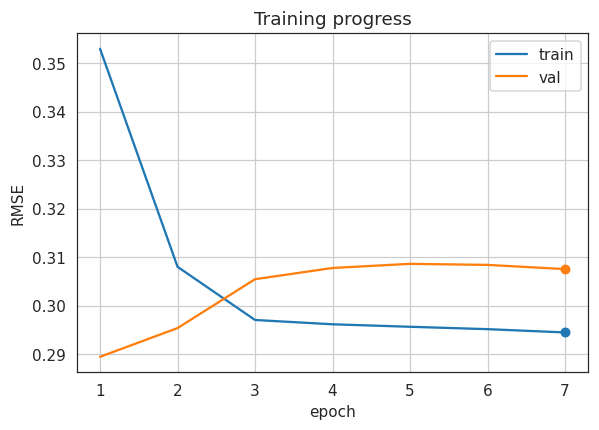

Epoch 1:   0%|          | 0/60 [00:01<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.3529 MAE=0.3156 R2=-0.4826 | "B": Acc=0.4369 Prec=0.2668 Rec=0.6093 F1=0.3711 AUROC=0.4871
VALID→ "R": RMSE=0.2894 MAE=0.2360 R2=-0.0312 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.5548


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.3080 MAE=0.2601 R2=-0.1291 | "B": Acc=0.3705 Prec=0.2707 Rec=0.7724 F1=0.4009 AUROC=0.4927
VALID→ "R": RMSE=0.2954 MAE=0.2103 R2=-0.0738 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.5144


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2970 MAE=0.2367 R2=-0.0502 | "B": Acc=0.3449 Prec=0.2724 Rec=0.8392 F1=0.4113 AUROC=0.4979
VALID→ "R": RMSE=0.3054 MAE=0.2076 R2=-0.1483 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4693


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2961 MAE=0.2294 R2=-0.0440 | "B": Acc=0.3377 Prec=0.2725 Rec=0.8559 F1=0.4134 AUROC=0.4998
VALID→ "R": RMSE=0.3078 MAE=0.2075 R2=-0.1657 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4644


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2956 MAE=0.2265 R2=-0.0404 | "B": Acc=0.3372 Prec=0.2726 Rec=0.8579 F1=0.4138 AUROC=0.5001
VALID→ "R": RMSE=0.3086 MAE=0.2073 R2=-0.1722 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4626


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2951 MAE=0.2249 R2=-0.0369 | "B": Acc=0.3391 Prec=0.2728 Rec=0.8552 F1=0.4137 AUROC=0.5004
VALID→ "R": RMSE=0.3084 MAE=0.2071 R2=-0.1705 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4612


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2945 MAE=0.2240 R2=-0.0322 | "B": Acc=0.3416 Prec=0.2724 Rec=0.8465 F1=0.4122 AUROC=0.4986
VALID→ "R": RMSE=0.3075 MAE=0.2068 R2=-0.1639 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4580
Early stopping at epoch 7
✅ Final best model (_fin) saved: AAPL_0.28945_fin.pth
Delete variables to free memory...


[I 2025-09-18 20:26:18,700] Trial 2 finished with value: 0.2894492447376251 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.33170857213912447, 'DROPOUT_LONG': 0.3024892715686228, 'ATT_DROPOUT': 0.07868937748133675, 'INITIAL_LR': 1.0812832487300233e-05, 'ETA_MIN': 6.717152906291489e-06, 'WEIGHT_DECAY': 0.0012530703694162708, 'CLIPNORM': 2.1297849257576766}. Best is trial 1 with value: 0.24039407074451447.



▶ Trial 3 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.19972960093106967, 'DROPOUT_LONG': 0.29165243303083405, 'ATT_DROPOUT': 0.13242372250905166, 'INITIAL_LR': 8.912597472476992e-05, 'ETA_MIN': 2.1069357381732355e-06, 'WEIGHT_DECAY': 9.149246671922074e-05, 'CLIPNORM': 8.887892717513264}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['adx_14', 'atr_14', 'ret', 'atr_pct_14', 'log_ret', 'macd_signal_12_26_9', 'bb_hband_20', 'body', 'bb_w_20', 'eng_vwap', 'minus_di_14', 'body_pct', 'hour', 'eng_obv', 'vol_spike_14', 'macd_diff_12_26_9', 'sma_28', 'eng_sma_long', 'obv_pct_14', 'eng_macd']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


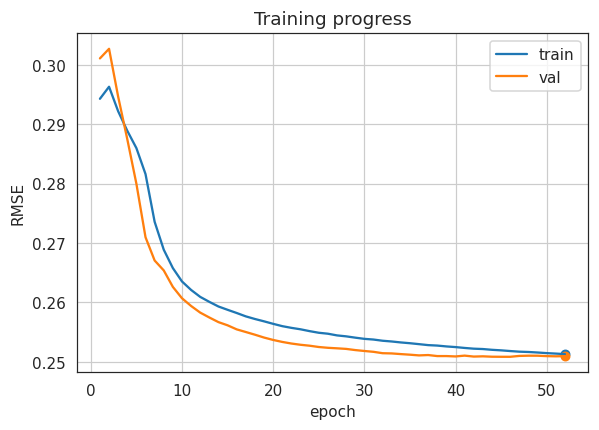

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2943 MAE=0.2288 R2=-0.0264 | "B": Acc=0.6143 Prec=0.2744 Rec=0.2397 F1=0.2558 AUROC=0.4956
VALID→ "R": RMSE=0.3011 MAE=0.2056 R2=-0.1004 | "B": Acc=0.7117 Prec=0.4855 Rec=0.0609 F1=0.1082 AUROC=0.6308


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2963 MAE=0.2355 R2=-0.0406 | "B": Acc=0.5609 Prec=0.2821 Rec=0.3801 F1=0.3238 AUROC=0.5070
VALID→ "R": RMSE=0.3027 MAE=0.2044 R2=-0.1123 | "B": Acc=0.7106 Prec=0.4890 Rec=0.1633 F1=0.2448 AUROC=0.6429


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2922 MAE=0.2269 R2=-0.0118 | "B": Acc=0.5450 Prec=0.2822 Rec=0.4177 F1=0.3368 AUROC=0.5078
VALID→ "R": RMSE=0.2946 MAE=0.2023 R2=-0.0538 | "B": Acc=0.6909 Prec=0.4538 Rec=0.3722 F1=0.4089 AUROC=0.6556


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2889 MAE=0.2250 R2=0.0108 | "B": Acc=0.5381 Prec=0.2865 Rec=0.4495 F1=0.3499 AUROC=0.5154
VALID→ "R": RMSE=0.2875 MAE=0.2004 R2=-0.0033 | "B": Acc=0.6699 Prec=0.4334 Rec=0.4851 F1=0.4578 AUROC=0.6647


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2860 MAE=0.2241 R2=0.0307 | "B": Acc=0.5396 Prec=0.2880 Rec=0.4513 F1=0.3517 AUROC=0.5177
VALID→ "R": RMSE=0.2800 MAE=0.1989 R2=0.0485 | "B": Acc=0.6333 Prec=0.4064 Rec=0.6001 F1=0.4846 AUROC=0.6704


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2816 MAE=0.2208 R2=0.0601 | "B": Acc=0.5413 Prec=0.2939 Rec=0.4693 F1=0.3615 AUROC=0.5269
VALID→ "R": RMSE=0.2710 MAE=0.1995 R2=0.1087 | "B": Acc=0.6121 Prec=0.3946 Rec=0.6561 F1=0.4929 AUROC=0.6744


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2736 MAE=0.2123 R2=0.1130 | "B": Acc=0.5544 Prec=0.2984 Rec=0.4520 F1=0.3595 AUROC=0.5321
VALID→ "R": RMSE=0.2671 MAE=0.2045 R2=0.1342 | "B": Acc=0.5860 Prec=0.3822 Rec=0.7157 F1=0.4983 AUROC=0.6758


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2689 MAE=0.2070 R2=0.1432 | "B": Acc=0.5750 Prec=0.3056 Rec=0.4215 F1=0.3543 AUROC=0.5387
VALID→ "R": RMSE=0.2654 MAE=0.1990 R2=0.1450 | "B": Acc=0.6242 Prec=0.4041 Rec=0.6497 F1=0.4983 AUROC=0.6816


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2658 MAE=0.2039 R2=0.1628 | "B": Acc=0.5910 Prec=0.3072 Rec=0.3812 F1=0.3402 AUROC=0.5363
VALID→ "R": RMSE=0.2626 MAE=0.1955 R2=0.1628 | "B": Acc=0.6321 Prec=0.4093 Rec=0.6333 F1=0.4973 AUROC=0.6832


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2635 MAE=0.2028 R2=0.1769 | "B": Acc=0.5877 Prec=0.3015 Rec=0.3725 F1=0.3333 AUROC=0.5290
VALID→ "R": RMSE=0.2607 MAE=0.1928 R2=0.1750 | "B": Acc=0.6296 Prec=0.4078 Rec=0.6391 F1=0.4979 AUROC=0.6848


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2621 MAE=0.2016 R2=0.1858 | "B": Acc=0.5823 Prec=0.2985 Rec=0.3778 F1=0.3335 AUROC=0.5259
VALID→ "R": RMSE=0.2594 MAE=0.1910 R2=0.1832 | "B": Acc=0.6111 Prec=0.3968 Rec=0.6805 F1=0.5013 AUROC=0.6848


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2609 MAE=0.2006 R2=0.1931 | "B": Acc=0.5732 Prec=0.2962 Rec=0.3944 F1=0.3383 AUROC=0.5241
VALID→ "R": RMSE=0.2583 MAE=0.1899 R2=0.1902 | "B": Acc=0.5870 Prec=0.3831 Rec=0.7165 F1=0.4992 AUROC=0.6825


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2601 MAE=0.1998 R2=0.1982 | "B": Acc=0.5684 Prec=0.2933 Rec=0.3974 F1=0.3375 AUROC=0.5206
VALID→ "R": RMSE=0.2575 MAE=0.1889 R2=0.1953 | "B": Acc=0.5736 Prec=0.3760 Rec=0.7345 F1=0.4974 AUROC=0.6802


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2593 MAE=0.1990 R2=0.2031 | "B": Acc=0.5667 Prec=0.2903 Rec=0.3920 F1=0.3336 AUROC=0.5170
VALID→ "R": RMSE=0.2567 MAE=0.1882 R2=0.2002 | "B": Acc=0.5650 Prec=0.3715 Rec=0.7434 F1=0.4955 AUROC=0.6772


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2588 MAE=0.1985 R2=0.2065 | "B": Acc=0.5634 Prec=0.2889 Rec=0.3956 F1=0.3339 AUROC=0.5151
VALID→ "R": RMSE=0.2561 MAE=0.1874 R2=0.2035 | "B": Acc=0.5528 Prec=0.3667 Rec=0.7659 F1=0.4960 AUROC=0.6777


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2582 MAE=0.1978 R2=0.2098 | "B": Acc=0.5612 Prec=0.2872 Rec=0.3958 F1=0.3329 AUROC=0.5131
VALID→ "R": RMSE=0.2555 MAE=0.1869 R2=0.2078 | "B": Acc=0.5385 Prec=0.3602 Rec=0.7814 F1=0.4931 AUROC=0.6742


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2576 MAE=0.1973 R2=0.2132 | "B": Acc=0.5580 Prec=0.2851 Rec=0.3965 F1=0.3317 AUROC=0.5096
VALID→ "R": RMSE=0.2550 MAE=0.1862 R2=0.2105 | "B": Acc=0.5264 Prec=0.3544 Rec=0.7892 F1=0.4892 AUROC=0.6691


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2572 MAE=0.1968 R2=0.2159 | "B": Acc=0.5571 Prec=0.2842 Rec=0.3956 F1=0.3307 AUROC=0.5086
VALID→ "R": RMSE=0.2546 MAE=0.1856 R2=0.2133 | "B": Acc=0.5316 Prec=0.3557 Rec=0.7773 F1=0.4881 AUROC=0.6659


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2568 MAE=0.1964 R2=0.2183 | "B": Acc=0.5594 Prec=0.2832 Rec=0.3871 F1=0.3271 AUROC=0.5074
VALID→ "R": RMSE=0.2541 MAE=0.1852 R2=0.2163 | "B": Acc=0.5289 Prec=0.3533 Rec=0.7706 F1=0.4845 AUROC=0.6595


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2564 MAE=0.1961 R2=0.2209 | "B": Acc=0.5594 Prec=0.2821 Rec=0.3837 F1=0.3251 AUROC=0.5051
VALID→ "R": RMSE=0.2537 MAE=0.1848 R2=0.2188 | "B": Acc=0.5188 Prec=0.3484 Rec=0.7752 F1=0.4807 AUROC=0.6531


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2560 MAE=0.1957 R2=0.2233 | "B": Acc=0.5528 Prec=0.2793 Rec=0.3901 F1=0.3255 AUROC=0.5013
VALID→ "R": RMSE=0.2533 MAE=0.1843 R2=0.2208 | "B": Acc=0.5014 Prec=0.3410 Rec=0.7886 F1=0.4761 AUROC=0.6464


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2557 MAE=0.1954 R2=0.2250 | "B": Acc=0.5524 Prec=0.2804 Rec=0.3946 F1=0.3278 AUROC=0.5036
VALID→ "R": RMSE=0.2531 MAE=0.1839 R2=0.2225 | "B": Acc=0.5050 Prec=0.3400 Rec=0.7681 F1=0.4714 AUROC=0.6355


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2555 MAE=0.1952 R2=0.2265 | "B": Acc=0.5487 Prec=0.2777 Rec=0.3943 F1=0.3259 AUROC=0.4989
VALID→ "R": RMSE=0.2529 MAE=0.1836 R2=0.2238 | "B": Acc=0.4914 Prec=0.3355 Rec=0.7855 F1=0.4702 AUROC=0.6355


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2552 MAE=0.1948 R2=0.2283 | "B": Acc=0.5468 Prec=0.2795 Rec=0.4045 F1=0.3306 AUROC=0.5018
VALID→ "R": RMSE=0.2527 MAE=0.1832 R2=0.2248 | "B": Acc=0.4953 Prec=0.3349 Rec=0.7672 F1=0.4662 AUROC=0.6272


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2549 MAE=0.1947 R2=0.2300 | "B": Acc=0.5456 Prec=0.2774 Rec=0.4005 F1=0.3278 AUROC=0.4987
VALID→ "R": RMSE=0.2525 MAE=0.1830 R2=0.2261 | "B": Acc=0.4898 Prec=0.3316 Rec=0.7635 F1=0.4624 AUROC=0.6195


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2547 MAE=0.1944 R2=0.2310 | "B": Acc=0.5442 Prec=0.2781 Rec=0.4061 F1=0.3302 AUROC=0.4996
VALID→ "R": RMSE=0.2524 MAE=0.1827 R2=0.2269 | "B": Acc=0.4829 Prec=0.3294 Rec=0.7721 F1=0.4617 AUROC=0.6196


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2544 MAE=0.1942 R2=0.2327 | "B": Acc=0.5417 Prec=0.2780 Rec=0.4111 F1=0.3317 AUROC=0.4994
VALID→ "R": RMSE=0.2523 MAE=0.1825 R2=0.2274 | "B": Acc=0.4802 Prec=0.3285 Rec=0.7749 F1=0.4614 AUROC=0.6190


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2543 MAE=0.1941 R2=0.2336 | "B": Acc=0.5434 Prec=0.2800 Rec=0.4140 F1=0.3341 AUROC=0.5028
VALID→ "R": RMSE=0.2522 MAE=0.1823 R2=0.2280 | "B": Acc=0.4907 Prec=0.3320 Rec=0.7639 F1=0.4629 AUROC=0.6207


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2541 MAE=0.1939 R2=0.2350 | "B": Acc=0.5420 Prec=0.2786 Rec=0.4127 F1=0.3327 AUROC=0.5008
VALID→ "R": RMSE=0.2520 MAE=0.1822 R2=0.2293 | "B": Acc=0.4736 Prec=0.3256 Rec=0.7767 F1=0.4588 AUROC=0.6141


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2539 MAE=0.1937 R2=0.2362 | "B": Acc=0.5380 Prec=0.2776 Rec=0.4182 F1=0.3337 AUROC=0.4991
VALID→ "R": RMSE=0.2518 MAE=0.1820 R2=0.2302 | "B": Acc=0.4699 Prec=0.3246 Rec=0.7822 F1=0.4588 AUROC=0.6148


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2537 MAE=0.1937 R2=0.2369 | "B": Acc=0.5375 Prec=0.2793 Rec=0.4252 F1=0.3371 AUROC=0.5020
VALID→ "R": RMSE=0.2517 MAE=0.1819 R2=0.2310 | "B": Acc=0.4737 Prec=0.3264 Rec=0.7817 F1=0.4605 AUROC=0.6175


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2535 MAE=0.1936 R2=0.2381 | "B": Acc=0.5366 Prec=0.2799 Rec=0.4293 F1=0.3389 AUROC=0.5028
VALID→ "R": RMSE=0.2514 MAE=0.1819 R2=0.2325 | "B": Acc=0.4613 Prec=0.3225 Rec=0.7947 F1=0.4588 AUROC=0.6161


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2534 MAE=0.1935 R2=0.2388 | "B": Acc=0.5339 Prec=0.2806 Rec=0.4378 F1=0.3420 AUROC=0.5051
VALID→ "R": RMSE=0.2514 MAE=0.1817 R2=0.2327 | "B": Acc=0.4637 Prec=0.3244 Rec=0.8003 F1=0.4616 AUROC=0.6214


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2533 MAE=0.1934 R2=0.2398 | "B": Acc=0.5378 Prec=0.2820 Rec=0.4341 F1=0.3419 AUROC=0.5066
VALID→ "R": RMSE=0.2513 MAE=0.1816 R2=0.2334 | "B": Acc=0.4632 Prec=0.3239 Rec=0.7985 F1=0.4608 AUROC=0.6199


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2531 MAE=0.1932 R2=0.2406 | "B": Acc=0.5340 Prec=0.2807 Rec=0.4380 F1=0.3422 AUROC=0.5051
VALID→ "R": RMSE=0.2512 MAE=0.1815 R2=0.2340 | "B": Acc=0.4506 Prec=0.3196 Rec=0.8083 F1=0.4581 AUROC=0.6163


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2530 MAE=0.1931 R2=0.2415 | "B": Acc=0.5320 Prec=0.2806 Rec=0.4425 F1=0.3435 AUROC=0.5046
VALID→ "R": RMSE=0.2511 MAE=0.1814 R2=0.2347 | "B": Acc=0.4488 Prec=0.3209 Rec=0.8229 F1=0.4617 AUROC=0.6233


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2528 MAE=0.1930 R2=0.2425 | "B": Acc=0.5324 Prec=0.2822 Rec=0.4471 F1=0.3460 AUROC=0.5072
VALID→ "R": RMSE=0.2511 MAE=0.1813 R2=0.2344 | "B": Acc=0.4573 Prec=0.3230 Rec=0.8112 F1=0.4621 AUROC=0.6225


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2527 MAE=0.1928 R2=0.2430 | "B": Acc=0.5333 Prec=0.2816 Rec=0.4430 F1=0.3443 AUROC=0.5066
VALID→ "R": RMSE=0.2510 MAE=0.1812 R2=0.2354 | "B": Acc=0.4517 Prec=0.3214 Rec=0.8172 F1=0.4613 AUROC=0.6211


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2526 MAE=0.1927 R2=0.2438 | "B": Acc=0.5321 Prec=0.2832 Rec=0.4517 F1=0.3481 AUROC=0.5089
VALID→ "R": RMSE=0.2510 MAE=0.1811 R2=0.2354 | "B": Acc=0.4524 Prec=0.3215 Rec=0.8161 F1=0.4613 AUROC=0.6213


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2525 MAE=0.1925 R2=0.2445 | "B": Acc=0.5326 Prec=0.2829 Rec=0.4494 F1=0.3472 AUROC=0.5082
VALID→ "R": RMSE=0.2509 MAE=0.1811 R2=0.2358 | "B": Acc=0.4519 Prec=0.3214 Rec=0.8167 F1=0.4613 AUROC=0.6209


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2523 MAE=0.1925 R2=0.2454 | "B": Acc=0.5311 Prec=0.2836 Rec=0.4552 F1=0.3494 AUROC=0.5094
VALID→ "R": RMSE=0.2510 MAE=0.1808 R2=0.2350 | "B": Acc=0.4522 Prec=0.3213 Rec=0.8152 F1=0.4609 AUROC=0.6198


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2522 MAE=0.1923 R2=0.2461 | "B": Acc=0.5319 Prec=0.2833 Rec=0.4526 F1=0.3485 AUROC=0.5090
VALID→ "R": RMSE=0.2509 MAE=0.1809 R2=0.2359 | "B": Acc=0.4538 Prec=0.3224 Rec=0.8182 F1=0.4626 AUROC=0.6223


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2521 MAE=0.1923 R2=0.2465 | "B": Acc=0.5313 Prec=0.2832 Rec=0.4536 F1=0.3487 AUROC=0.5093
VALID→ "R": RMSE=0.2509 MAE=0.1808 R2=0.2357 | "B": Acc=0.4552 Prec=0.3221 Rec=0.8115 F1=0.4612 AUROC=0.6198


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2520 MAE=0.1922 R2=0.2472 | "B": Acc=0.5317 Prec=0.2821 Rec=0.4486 F1=0.3464 AUROC=0.5076
VALID→ "R": RMSE=0.2509 MAE=0.1807 R2=0.2361 | "B": Acc=0.4573 Prec=0.3230 Rec=0.8112 F1=0.4620 AUROC=0.6208


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2519 MAE=0.1921 R2=0.2478 | "B": Acc=0.5312 Prec=0.2838 Rec=0.4558 F1=0.3498 AUROC=0.5099
VALID→ "R": RMSE=0.2508 MAE=0.1806 R2=0.2361 | "B": Acc=0.4555 Prec=0.3225 Rec=0.8136 F1=0.4619 AUROC=0.6205


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2518 MAE=0.1921 R2=0.2485 | "B": Acc=0.5335 Prec=0.2834 Rec=0.4491 F1=0.3475 AUROC=0.5092
VALID→ "R": RMSE=0.2508 MAE=0.1805 R2=0.2362 | "B": Acc=0.4594 Prec=0.3230 Rec=0.8047 F1=0.4610 AUROC=0.6184


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2517 MAE=0.1920 R2=0.2491 | "B": Acc=0.5304 Prec=0.2835 Rec=0.4567 F1=0.3498 AUROC=0.5090
VALID→ "R": RMSE=0.2510 MAE=0.1804 R2=0.2353 | "B": Acc=0.4510 Prec=0.3213 Rec=0.8185 F1=0.4614 AUROC=0.6204


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2517 MAE=0.1919 R2=0.2494 | "B": Acc=0.5298 Prec=0.2839 Rec=0.4595 F1=0.3509 AUROC=0.5103
VALID→ "R": RMSE=0.2510 MAE=0.1803 R2=0.2350 | "B": Acc=0.4570 Prec=0.3229 Rec=0.8115 F1=0.4620 AUROC=0.6203


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2516 MAE=0.1918 R2=0.2500 | "B": Acc=0.5285 Prec=0.2828 Rec=0.4587 F1=0.3499 AUROC=0.5089
VALID→ "R": RMSE=0.2510 MAE=0.1802 R2=0.2351 | "B": Acc=0.4532 Prec=0.3226 Rec=0.8213 F1=0.4632 AUROC=0.6237


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2515 MAE=0.1918 R2=0.2506 | "B": Acc=0.5287 Prec=0.2839 Rec=0.4623 F1=0.3517 AUROC=0.5106
VALID→ "R": RMSE=0.2510 MAE=0.1802 R2=0.2355 | "B": Acc=0.4571 Prec=0.3230 Rec=0.8116 F1=0.4621 AUROC=0.6204


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2514 MAE=0.1918 R2=0.2510 | "B": Acc=0.5307 Prec=0.2845 Rec=0.4596 F1=0.3514 AUROC=0.5106
VALID→ "R": RMSE=0.2509 MAE=0.1802 R2=0.2357 | "B": Acc=0.4632 Prec=0.3251 Rec=0.8074 F1=0.4636 AUROC=0.6235


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2513 MAE=0.1917 R2=0.2515 | "B": Acc=0.5312 Prec=0.2845 Rec=0.4584 F1=0.3511 AUROC=0.5110
VALID→ "R": RMSE=0.2510 MAE=0.1801 R2=0.2355 | "B": Acc=0.4610 Prec=0.3248 Rec=0.8123 F1=0.4641 AUROC=0.6243
Early stopping at epoch 52
✅ Final best model (_fin) saved: AAPL_0.25084_fin.pth
Delete variables to free memory...


[I 2025-09-18 21:19:05,784] Trial 3 finished with value: 0.2508428692817688 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.19972960093106967, 'DROPOUT_LONG': 0.29165243303083405, 'ATT_DROPOUT': 0.13242372250905166, 'INITIAL_LR': 8.912597472476992e-05, 'ETA_MIN': 2.1069357381732355e-06, 'WEIGHT_DECAY': 9.149246671922074e-05, 'CLIPNORM': 8.887892717513264}. Best is trial 1 with value: 0.24039407074451447.



▶ Trial 4 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.08294983544607068, 'DROPOUT_LONG': 0.3262779546625068, 'ATT_DROPOUT': 0.15760948441688413, 'INITIAL_LR': 2.366323161074841e-05, 'ETA_MIN': 3.4169559661323754e-06, 'WEIGHT_DECAY': 5.2523740587890315e-05, 'CLIPNORM': 5.441612036024297}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['adx_14', 'atr_14', 'ret', 'atr_pct_14', 'log_ret', 'macd_signal_12_26_9', 'bb_hband_20', 'body', 'bb_w_20', 'eng_vwap', 'minus_di_14', 'body_pct', 'hour', 'eng_obv', 'vol_spike_14', 'macd_diff_12_26_9', 'sma_28', 'eng_sma_long', 'obv_pct_14', 'eng_macd']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


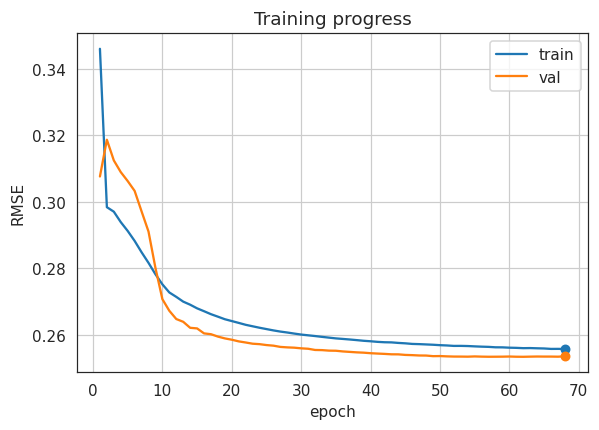

Epoch 1:   0%|          | 0/60 [00:01<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.3461 MAE=0.2980 R2=-0.4257 | "B": Acc=0.5733 Prec=0.2803 Rec=0.3604 F1=0.3154 AUROC=0.5094
VALID→ "R": RMSE=0.3077 MAE=0.2101 R2=-0.1649 | "B": Acc=0.7196 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.3892


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2984 MAE=0.2293 R2=-0.0600 | "B": Acc=0.6363 Prec=0.2576 Rec=0.1775 F1=0.2101 AUROC=0.4832
VALID→ "R": RMSE=0.3187 MAE=0.2102 R2=-0.2502 | "B": Acc=0.7196 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.3871


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2971 MAE=0.2247 R2=-0.0504 | "B": Acc=0.6246 Prec=0.2561 Rec=0.1979 F1=0.2233 AUROC=0.4826
VALID→ "R": RMSE=0.3125 MAE=0.2077 R2=-0.2019 | "B": Acc=0.7196 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.3912


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2939 MAE=0.2235 R2=-0.0284 | "B": Acc=0.6043 Prec=0.2626 Rec=0.2496 F1=0.2560 AUROC=0.4882
VALID→ "R": RMSE=0.3090 MAE=0.2062 R2=-0.1750 | "B": Acc=0.7196 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.4036


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2913 MAE=0.2217 R2=-0.0098 | "B": Acc=0.5865 Prec=0.2686 Rec=0.2998 F1=0.2833 AUROC=0.4948
VALID→ "R": RMSE=0.3063 MAE=0.2047 R2=-0.1545 | "B": Acc=0.7196 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.4346


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2883 MAE=0.2196 R2=0.0109 | "B": Acc=0.5723 Prec=0.2756 Rec=0.3493 F1=0.3081 AUROC=0.5042
VALID→ "R": RMSE=0.3033 MAE=0.2029 R2=-0.1323 | "B": Acc=0.7196 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.4896


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2848 MAE=0.2175 R2=0.0342 | "B": Acc=0.5615 Prec=0.2830 Rec=0.3966 F1=0.3303 AUROC=0.5148
VALID→ "R": RMSE=0.2972 MAE=0.2001 R2=-0.0868 | "B": Acc=0.7195 Prec=0.1852 Rec=0.0000 F1=0.0001 AUROC=0.5576


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2817 MAE=0.2181 R2=0.0557 | "B": Acc=0.5463 Prec=0.2915 Rec=0.4642 F1=0.3581 AUROC=0.5289
VALID→ "R": RMSE=0.2911 MAE=0.1975 R2=-0.0428 | "B": Acc=0.7198 Prec=0.5418 Rec=0.0059 F1=0.0116 AUROC=0.6053


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2782 MAE=0.2157 R2=0.0786 | "B": Acc=0.5413 Prec=0.2988 Rec=0.5069 F1=0.3760 AUROC=0.5424
VALID→ "R": RMSE=0.2801 MAE=0.1949 R2=0.0342 | "B": Acc=0.7231 Prec=0.5513 Rec=0.0669 F1=0.1193 AUROC=0.6417


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2752 MAE=0.2136 R2=0.0985 | "B": Acc=0.5355 Prec=0.3049 Rec=0.5500 F1=0.3923 AUROC=0.5560
VALID→ "R": RMSE=0.2707 MAE=0.1940 R2=0.0979 | "B": Acc=0.7217 Prec=0.5084 Rec=0.2255 F1=0.3124 AUROC=0.6636


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2727 MAE=0.2108 R2=0.1145 | "B": Acc=0.5294 Prec=0.3085 Rec=0.5845 F1=0.4038 AUROC=0.5651
VALID→ "R": RMSE=0.2672 MAE=0.1927 R2=0.1211 | "B": Acc=0.7144 Prec=0.4875 Rec=0.3575 F1=0.4125 AUROC=0.6791


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2714 MAE=0.2089 R2=0.1231 | "B": Acc=0.5224 Prec=0.3107 Rec=0.6166 F1=0.4132 AUROC=0.5728
VALID→ "R": RMSE=0.2648 MAE=0.1920 R2=0.1373 | "B": Acc=0.7030 Prec=0.4689 Rec=0.4463 F1=0.4573 AUROC=0.6896


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2700 MAE=0.2077 R2=0.1323 | "B": Acc=0.5160 Prec=0.3108 Rec=0.6366 F1=0.4176 AUROC=0.5765
VALID→ "R": RMSE=0.2639 MAE=0.1906 R2=0.1427 | "B": Acc=0.6982 Prec=0.4639 Rec=0.4897 F1=0.4764 AUROC=0.6981


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2691 MAE=0.2067 R2=0.1382 | "B": Acc=0.5142 Prec=0.3123 Rec=0.6505 F1=0.4220 AUROC=0.5811
VALID→ "R": RMSE=0.2621 MAE=0.1902 R2=0.1544 | "B": Acc=0.6917 Prec=0.4573 Rec=0.5320 F1=0.4918 AUROC=0.7041


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2680 MAE=0.2060 R2=0.1452 | "B": Acc=0.5090 Prec=0.3114 Rec=0.6607 F1=0.4233 AUROC=0.5819
VALID→ "R": RMSE=0.2619 MAE=0.1888 R2=0.1556 | "B": Acc=0.6858 Prec=0.4519 Rec=0.5670 F1=0.5030 AUROC=0.7083


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2671 MAE=0.2050 R2=0.1507 | "B": Acc=0.5066 Prec=0.3114 Rec=0.6683 F1=0.4248 AUROC=0.5833
VALID→ "R": RMSE=0.2604 MAE=0.1886 R2=0.1652 | "B": Acc=0.6779 Prec=0.4450 Rec=0.6016 F1=0.5116 AUROC=0.7110


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2662 MAE=0.2043 R2=0.1564 | "B": Acc=0.5038 Prec=0.3108 Rec=0.6732 F1=0.4252 AUROC=0.5836
VALID→ "R": RMSE=0.2602 MAE=0.1876 R2=0.1668 | "B": Acc=0.6770 Prec=0.4445 Rec=0.6080 F1=0.5135 AUROC=0.7126


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2655 MAE=0.2036 R2=0.1612 | "B": Acc=0.5012 Prec=0.3105 Rec=0.6794 F1=0.4262 AUROC=0.5839
VALID→ "R": RMSE=0.2595 MAE=0.1871 R2=0.1714 | "B": Acc=0.6691 Prec=0.4377 Rec=0.6328 F1=0.5175 AUROC=0.7137


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2647 MAE=0.2029 R2=0.1660 | "B": Acc=0.5041 Prec=0.3111 Rec=0.6739 F1=0.4256 AUROC=0.5841
VALID→ "R": RMSE=0.2589 MAE=0.1866 R2=0.1749 | "B": Acc=0.6704 Prec=0.4388 Rec=0.6290 F1=0.5170 AUROC=0.7138


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2641 MAE=0.2024 R2=0.1695 | "B": Acc=0.5041 Prec=0.3109 Rec=0.6730 F1=0.4253 AUROC=0.5839
VALID→ "R": RMSE=0.2585 MAE=0.1862 R2=0.1774 | "B": Acc=0.6661 Prec=0.4350 Rec=0.6382 F1=0.5174 AUROC=0.7135


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2636 MAE=0.2018 R2=0.1730 | "B": Acc=0.5051 Prec=0.3108 Rec=0.6693 F1=0.4245 AUROC=0.5830
VALID→ "R": RMSE=0.2580 MAE=0.1860 R2=0.1806 | "B": Acc=0.6719 Prec=0.4396 Rec=0.6190 F1=0.5141 AUROC=0.7125


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2630 MAE=0.2012 R2=0.1766 | "B": Acc=0.5069 Prec=0.3107 Rec=0.6635 F1=0.4232 AUROC=0.5818
VALID→ "R": RMSE=0.2577 MAE=0.1857 R2=0.1827 | "B": Acc=0.6724 Prec=0.4399 Rec=0.6153 F1=0.5130 AUROC=0.7116


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2626 MAE=0.2009 R2=0.1793 | "B": Acc=0.5085 Prec=0.3104 Rec=0.6567 F1=0.4215 AUROC=0.5802
VALID→ "R": RMSE=0.2573 MAE=0.1855 R2=0.1850 | "B": Acc=0.6720 Prec=0.4390 Rec=0.6116 F1=0.5112 AUROC=0.7101


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2621 MAE=0.2005 R2=0.1821 | "B": Acc=0.5104 Prec=0.3102 Rec=0.6501 F1=0.4200 AUROC=0.5783
VALID→ "R": RMSE=0.2572 MAE=0.1852 R2=0.1859 | "B": Acc=0.6742 Prec=0.4405 Rec=0.5987 F1=0.5075 AUROC=0.7079


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2617 MAE=0.2002 R2=0.1846 | "B": Acc=0.5115 Prec=0.3097 Rec=0.6442 F1=0.4183 AUROC=0.5766
VALID→ "R": RMSE=0.2569 MAE=0.1851 R2=0.1876 | "B": Acc=0.6751 Prec=0.4407 Rec=0.5898 F1=0.5045 AUROC=0.7055


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2613 MAE=0.1999 R2=0.1871 | "B": Acc=0.5082 Prec=0.3073 Rec=0.6408 F1=0.4154 AUROC=0.5726
VALID→ "R": RMSE=0.2567 MAE=0.1849 R2=0.1887 | "B": Acc=0.6706 Prec=0.4361 Rec=0.5966 F1=0.5039 AUROC=0.7034


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2610 MAE=0.1995 R2=0.1893 | "B": Acc=0.5088 Prec=0.3064 Rec=0.6340 F1=0.4131 AUROC=0.5699
VALID→ "R": RMSE=0.2564 MAE=0.1848 R2=0.1911 | "B": Acc=0.6740 Prec=0.4385 Rec=0.5801 F1=0.4995 AUROC=0.7005


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2607 MAE=0.1993 R2=0.1910 | "B": Acc=0.5092 Prec=0.3054 Rec=0.6277 F1=0.4109 AUROC=0.5671
VALID→ "R": RMSE=0.2562 MAE=0.1847 R2=0.1920 | "B": Acc=0.6757 Prec=0.4392 Rec=0.5652 F1=0.4943 AUROC=0.6972


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2604 MAE=0.1991 R2=0.1930 | "B": Acc=0.5089 Prec=0.3045 Rec=0.6239 F1=0.4092 AUROC=0.5651
VALID→ "R": RMSE=0.2561 MAE=0.1845 R2=0.1926 | "B": Acc=0.6770 Prec=0.4392 Rec=0.5487 F1=0.4879 AUROC=0.6930


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2601 MAE=0.1988 R2=0.1949 | "B": Acc=0.5095 Prec=0.3029 Rec=0.6142 F1=0.4058 AUROC=0.5612
VALID→ "R": RMSE=0.2559 MAE=0.1843 R2=0.1938 | "B": Acc=0.6773 Prec=0.4381 Rec=0.5336 F1=0.4812 AUROC=0.6891


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2599 MAE=0.1987 R2=0.1962 | "B": Acc=0.5065 Prec=0.3015 Rec=0.6152 F1=0.4047 AUROC=0.5585
VALID→ "R": RMSE=0.2558 MAE=0.1842 R2=0.1946 | "B": Acc=0.6749 Prec=0.4345 Rec=0.5289 F1=0.4771 AUROC=0.6854


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2596 MAE=0.1985 R2=0.1976 | "B": Acc=0.5043 Prec=0.3001 Rec=0.6143 F1=0.4032 AUROC=0.5559
VALID→ "R": RMSE=0.2554 MAE=0.1843 R2=0.1969 | "B": Acc=0.6708 Prec=0.4294 Rec=0.5284 F1=0.4738 AUROC=0.6813


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2594 MAE=0.1983 R2=0.1991 | "B": Acc=0.5017 Prec=0.2986 Rec=0.6135 F1=0.4017 AUROC=0.5535
VALID→ "R": RMSE=0.2554 MAE=0.1841 R2=0.1972 | "B": Acc=0.6651 Prec=0.4226 Rec=0.5304 F1=0.4704 AUROC=0.6770


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2592 MAE=0.1982 R2=0.2006 | "B": Acc=0.5021 Prec=0.2984 Rec=0.6114 F1=0.4010 AUROC=0.5530
VALID→ "R": RMSE=0.2552 MAE=0.1840 R2=0.1982 | "B": Acc=0.6688 Prec=0.4228 Rec=0.4955 F1=0.4563 AUROC=0.6718


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2589 MAE=0.1980 R2=0.2020 | "B": Acc=0.5010 Prec=0.2971 Rec=0.6079 F1=0.3991 AUROC=0.5498
VALID→ "R": RMSE=0.2552 MAE=0.1838 R2=0.1984 | "B": Acc=0.6620 Prec=0.4146 Rec=0.4982 F1=0.4525 AUROC=0.6669


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2588 MAE=0.1978 R2=0.2030 | "B": Acc=0.4981 Prec=0.2961 Rec=0.6106 F1=0.3989 AUROC=0.5486
VALID→ "R": RMSE=0.2550 MAE=0.1838 R2=0.1997 | "B": Acc=0.6589 Prec=0.4093 Rec=0.4883 F1=0.4453 AUROC=0.6619


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2586 MAE=0.1977 R2=0.2040 | "B": Acc=0.4972 Prec=0.2953 Rec=0.6091 F1=0.3978 AUROC=0.5469
VALID→ "R": RMSE=0.2549 MAE=0.1837 R2=0.2005 | "B": Acc=0.6580 Prec=0.4052 Rec=0.4696 F1=0.4351 AUROC=0.6564


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2584 MAE=0.1975 R2=0.2052 | "B": Acc=0.4970 Prec=0.2945 Rec=0.6053 F1=0.3962 AUROC=0.5449
VALID→ "R": RMSE=0.2547 MAE=0.1836 R2=0.2014 | "B": Acc=0.6583 Prec=0.4003 Rec=0.4391 F1=0.4188 AUROC=0.6503


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2582 MAE=0.1975 R2=0.2064 | "B": Acc=0.5002 Prec=0.2943 Rec=0.5962 F1=0.3941 AUROC=0.5438
VALID→ "R": RMSE=0.2546 MAE=0.1835 R2=0.2020 | "B": Acc=0.6617 Prec=0.3959 Rec=0.3924 F1=0.3941 AUROC=0.6435


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2581 MAE=0.1973 R2=0.2073 | "B": Acc=0.5001 Prec=0.2930 Rec=0.5900 F1=0.3916 AUROC=0.5413
VALID→ "R": RMSE=0.2545 MAE=0.1835 R2=0.2030 | "B": Acc=0.6596 Prec=0.3918 Rec=0.3873 F1=0.3895 AUROC=0.6402


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2579 MAE=0.1972 R2=0.2084 | "B": Acc=0.4977 Prec=0.2926 Rec=0.5942 F1=0.3921 AUROC=0.5410
VALID→ "R": RMSE=0.2544 MAE=0.1834 R2=0.2037 | "B": Acc=0.6548 Prec=0.3856 Rec=0.3894 F1=0.3875 AUROC=0.6359


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2578 MAE=0.1971 R2=0.2091 | "B": Acc=0.4987 Prec=0.2926 Rec=0.5915 F1=0.3915 AUROC=0.5403
VALID→ "R": RMSE=0.2543 MAE=0.1833 R2=0.2043 | "B": Acc=0.6559 Prec=0.3810 Rec=0.3636 F1=0.3721 AUROC=0.6299


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2577 MAE=0.1971 R2=0.2093 | "B": Acc=0.4972 Prec=0.2912 Rec=0.5886 F1=0.3896 AUROC=0.5376
VALID→ "R": RMSE=0.2541 MAE=0.1833 R2=0.2051 | "B": Acc=0.6517 Prec=0.3767 Rec=0.3699 F1=0.3733 AUROC=0.6268


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2576 MAE=0.1969 R2=0.2103 | "B": Acc=0.4961 Prec=0.2905 Rec=0.5882 F1=0.3890 AUROC=0.5371
VALID→ "R": RMSE=0.2541 MAE=0.1831 R2=0.2052 | "B": Acc=0.6497 Prec=0.3701 Rec=0.3550 F1=0.3624 AUROC=0.6205


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2574 MAE=0.1969 R2=0.2111 | "B": Acc=0.4946 Prec=0.2897 Rec=0.5878 F1=0.3881 AUROC=0.5352
VALID→ "R": RMSE=0.2540 MAE=0.1832 R2=0.2062 | "B": Acc=0.6485 Prec=0.3657 Rec=0.3451 F1=0.3551 AUROC=0.6156


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2573 MAE=0.1966 R2=0.2122 | "B": Acc=0.4946 Prec=0.2895 Rec=0.5872 F1=0.3878 AUROC=0.5346
VALID→ "R": RMSE=0.2539 MAE=0.1831 R2=0.2067 | "B": Acc=0.6472 Prec=0.3607 Rec=0.3341 F1=0.3469 AUROC=0.6099


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2572 MAE=0.1966 R2=0.2126 | "B": Acc=0.4945 Prec=0.2888 Rec=0.5842 F1=0.3866 AUROC=0.5333
VALID→ "R": RMSE=0.2538 MAE=0.1830 R2=0.2073 | "B": Acc=0.6466 Prec=0.3570 Rec=0.3252 F1=0.3404 AUROC=0.6055


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2571 MAE=0.1966 R2=0.2131 | "B": Acc=0.4942 Prec=0.2887 Rec=0.5844 F1=0.3865 AUROC=0.5327
VALID→ "R": RMSE=0.2538 MAE=0.1829 R2=0.2074 | "B": Acc=0.6489 Prec=0.3531 Rec=0.3031 F1=0.3262 AUROC=0.5996


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2570 MAE=0.1965 R2=0.2137 | "B": Acc=0.4952 Prec=0.2875 Rec=0.5762 F1=0.3836 AUROC=0.5304
VALID→ "R": RMSE=0.2536 MAE=0.1829 R2=0.2086 | "B": Acc=0.6487 Prec=0.3495 Rec=0.2932 F1=0.3189 AUROC=0.5955


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2569 MAE=0.1963 R2=0.2145 | "B": Acc=0.4953 Prec=0.2871 Rec=0.5737 F1=0.3827 AUROC=0.5296
VALID→ "R": RMSE=0.2536 MAE=0.1828 R2=0.2084 | "B": Acc=0.6487 Prec=0.3459 Rec=0.2835 F1=0.3116 AUROC=0.5912


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2568 MAE=0.1962 R2=0.2150 | "B": Acc=0.4966 Prec=0.2872 Rec=0.5711 F1=0.3822 AUROC=0.5297
VALID→ "R": RMSE=0.2535 MAE=0.1828 R2=0.2090 | "B": Acc=0.6510 Prec=0.3443 Rec=0.2703 F1=0.3029 AUROC=0.5880


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2567 MAE=0.1961 R2=0.2158 | "B": Acc=0.4957 Prec=0.2860 Rec=0.5676 F1=0.3803 AUROC=0.5270
VALID→ "R": RMSE=0.2535 MAE=0.1827 R2=0.2093 | "B": Acc=0.6486 Prec=0.3400 Rec=0.2690 F1=0.3004 AUROC=0.5834


Epoch 53:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2567 MAE=0.1962 R2=0.2158 | "B": Acc=0.4952 Prec=0.2853 Rec=0.5657 F1=0.3793 AUROC=0.5262
VALID→ "R": RMSE=0.2535 MAE=0.1827 R2=0.2094 | "B": Acc=0.6497 Prec=0.3381 Rec=0.2603 F1=0.2942 AUROC=0.5805


Epoch 54:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2566 MAE=0.1961 R2=0.2161 | "B": Acc=0.4961 Prec=0.2856 Rec=0.5649 F1=0.3794 AUROC=0.5261
VALID→ "R": RMSE=0.2534 MAE=0.1825 R2=0.2095 | "B": Acc=0.6467 Prec=0.3353 Rec=0.2647 F1=0.2958 AUROC=0.5776


Epoch 55:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 055
TRAIN→ "R": RMSE=0.2565 MAE=0.1961 R2=0.2167 | "B": Acc=0.4948 Prec=0.2856 Rec=0.5682 F1=0.3802 AUROC=0.5265
VALID→ "R": RMSE=0.2535 MAE=0.1824 R2=0.2091 | "B": Acc=0.6450 Prec=0.3327 Rec=0.2645 F1=0.2947 AUROC=0.5748


Epoch 56:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 056
TRAIN→ "R": RMSE=0.2564 MAE=0.1959 R2=0.2172 | "B": Acc=0.4930 Prec=0.2851 Rec=0.5704 F1=0.3802 AUROC=0.5257
VALID→ "R": RMSE=0.2534 MAE=0.1823 R2=0.2095 | "B": Acc=0.6429 Prec=0.3318 Rec=0.2695 F1=0.2974 AUROC=0.5732


Epoch 57:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 057
TRAIN→ "R": RMSE=0.2564 MAE=0.1959 R2=0.2176 | "B": Acc=0.4907 Prec=0.2847 Rec=0.5736 F1=0.3805 AUROC=0.5255
VALID→ "R": RMSE=0.2534 MAE=0.1823 R2=0.2097 | "B": Acc=0.6410 Prec=0.3303 Rec=0.2728 F1=0.2988 AUROC=0.5715


Epoch 58:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 058
TRAIN→ "R": RMSE=0.2562 MAE=0.1958 R2=0.2184 | "B": Acc=0.4919 Prec=0.2851 Rec=0.5728 F1=0.3807 AUROC=0.5257
VALID→ "R": RMSE=0.2534 MAE=0.1822 R2=0.2096 | "B": Acc=0.6422 Prec=0.3278 Rec=0.2627 F1=0.2917 AUROC=0.5682


Epoch 59:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 059
TRAIN→ "R": RMSE=0.2562 MAE=0.1958 R2=0.2185 | "B": Acc=0.4910 Prec=0.2849 Rec=0.5742 F1=0.3808 AUROC=0.5254
VALID→ "R": RMSE=0.2534 MAE=0.1821 R2=0.2095 | "B": Acc=0.6416 Prec=0.3266 Rec=0.2618 F1=0.2906 AUROC=0.5660


Epoch 60:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 060
TRAIN→ "R": RMSE=0.2561 MAE=0.1958 R2=0.2191 | "B": Acc=0.4921 Prec=0.2844 Rec=0.5689 F1=0.3792 AUROC=0.5247
VALID→ "R": RMSE=0.2535 MAE=0.1820 R2=0.2093 | "B": Acc=0.6404 Prec=0.3250 Rec=0.2621 F1=0.2901 AUROC=0.5640


Epoch 61:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 061
TRAIN→ "R": RMSE=0.2561 MAE=0.1955 R2=0.2194 | "B": Acc=0.4904 Prec=0.2839 Rec=0.5708 F1=0.3792 AUROC=0.5240
VALID→ "R": RMSE=0.2534 MAE=0.1819 R2=0.2096 | "B": Acc=0.6379 Prec=0.3239 Rec=0.2679 F1=0.2932 AUROC=0.5629


Epoch 62:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 062
TRAIN→ "R": RMSE=0.2560 MAE=0.1955 R2=0.2200 | "B": Acc=0.4887 Prec=0.2841 Rec=0.5758 F1=0.3805 AUROC=0.5245
VALID→ "R": RMSE=0.2534 MAE=0.1819 R2=0.2098 | "B": Acc=0.6386 Prec=0.3220 Rec=0.2611 F1=0.2884 AUROC=0.5596


Epoch 63:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 063
TRAIN→ "R": RMSE=0.2560 MAE=0.1955 R2=0.2198 | "B": Acc=0.4903 Prec=0.2835 Rec=0.5693 F1=0.3786 AUROC=0.5236
VALID→ "R": RMSE=0.2534 MAE=0.1818 R2=0.2095 | "B": Acc=0.6401 Prec=0.3209 Rec=0.2539 F1=0.2835 AUROC=0.5569


Epoch 64:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 064
TRAIN→ "R": RMSE=0.2559 MAE=0.1954 R2=0.2202 | "B": Acc=0.4905 Prec=0.2832 Rec=0.5675 F1=0.3778 AUROC=0.5225
VALID→ "R": RMSE=0.2535 MAE=0.1817 R2=0.2093 | "B": Acc=0.6379 Prec=0.3207 Rec=0.2604 F1=0.2874 AUROC=0.5572


Epoch 65:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 065
TRAIN→ "R": RMSE=0.2559 MAE=0.1953 R2=0.2205 | "B": Acc=0.4907 Prec=0.2835 Rec=0.5685 F1=0.3783 AUROC=0.5230
VALID→ "R": RMSE=0.2535 MAE=0.1816 R2=0.2094 | "B": Acc=0.6401 Prec=0.3203 Rec=0.2527 F1=0.2825 AUROC=0.5554


Epoch 66:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 066
TRAIN→ "R": RMSE=0.2558 MAE=0.1952 R2=0.2213 | "B": Acc=0.4925 Prec=0.2831 Rec=0.5621 F1=0.3765 AUROC=0.5221
VALID→ "R": RMSE=0.2535 MAE=0.1816 R2=0.2094 | "B": Acc=0.6403 Prec=0.3196 Rec=0.2504 F1=0.2808 AUROC=0.5541


Epoch 67:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 067
TRAIN→ "R": RMSE=0.2558 MAE=0.1951 R2=0.2213 | "B": Acc=0.4923 Prec=0.2832 Rec=0.5630 F1=0.3768 AUROC=0.5219
VALID→ "R": RMSE=0.2534 MAE=0.1815 R2=0.2096 | "B": Acc=0.6399 Prec=0.3187 Rec=0.2498 F1=0.2801 AUROC=0.5530


Epoch 68:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 068
TRAIN→ "R": RMSE=0.2557 MAE=0.1952 R2=0.2215 | "B": Acc=0.4927 Prec=0.2829 Rec=0.5610 F1=0.3761 AUROC=0.5219
VALID→ "R": RMSE=0.2535 MAE=0.1814 R2=0.2089 | "B": Acc=0.6417 Prec=0.3179 Rec=0.2426 F1=0.2752 AUROC=0.5507
Early stopping at epoch 68
✅ Final best model (_fin) saved: AAPL_0.25339_fin.pth
Delete variables to free memory...


[I 2025-09-18 22:35:11,175] Trial 4 finished with value: 0.2533889710903168 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.08294983544607068, 'DROPOUT_LONG': 0.3262779546625068, 'ATT_DROPOUT': 0.15760948441688413, 'INITIAL_LR': 2.366323161074841e-05, 'ETA_MIN': 3.4169559661323754e-06, 'WEIGHT_DECAY': 5.2523740587890315e-05, 'CLIPNORM': 5.441612036024297}. Best is trial 1 with value: 0.24039407074451447.



▶ Trial 5 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.3031318341184864, 'DROPOUT_LONG': 0.3164850541454929, 'ATT_DROPOUT': 0.312154077001075, 'INITIAL_LR': 0.0005697269982458067, 'ETA_MIN': 1.656180833193771e-06, 'WEIGHT_DECAY': 2.5034626851345667e-05, 'CLIPNORM': 3.1670909318329223}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['adx_14', 'atr_14', 'ret', 'atr_pct_14', 'log_ret', 'macd_signal_12_26_9', 'bb_hband_20', 'body', 'bb_w_20', 'eng_vwap', 'minus_di_14', 'body_pct', 'hour', 'eng_obv', 'vol_spike_14', 'macd_diff_12_26_9', 'sma_28', 'eng_sma_long', 'obv_pct_14', 'eng_macd']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


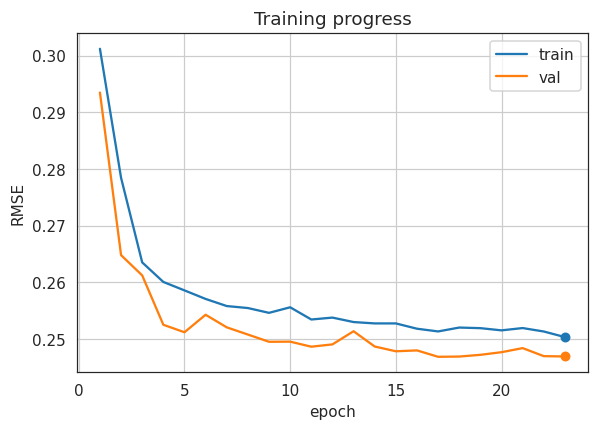

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.3012 MAE=0.2378 R2=-0.0634 | "B": Acc=0.5964 Prec=0.2976 Rec=0.3163 F1=0.3067 AUROC=0.5185
VALID→ "R": RMSE=0.2935 MAE=0.2010 R2=-0.0311 | "B": Acc=0.6207 Prec=0.3546 Rec=0.3478 F1=0.3511 AUROC=0.5961


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2784 MAE=0.2155 R2=0.0914 | "B": Acc=0.6162 Prec=0.2831 Rec=0.2353 F1=0.2570 AUROC=0.5052
VALID→ "R": RMSE=0.2648 MAE=0.2047 R2=0.1608 | "B": Acc=0.7044 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.4331


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2635 MAE=0.2031 R2=0.1863 | "B": Acc=0.6442 Prec=0.2442 Rec=0.1247 F1=0.1651 AUROC=0.4676
VALID→ "R": RMSE=0.2612 MAE=0.1860 R2=0.1833 | "B": Acc=0.7031 Prec=0.0689 Rec=0.0005 F1=0.0010 AUROC=0.3478


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2600 MAE=0.2000 R2=0.2075 | "B": Acc=0.6042 Prec=0.2080 Rec=0.1435 F1=0.1698 AUROC=0.4241
VALID→ "R": RMSE=0.2525 MAE=0.1916 R2=0.2370 | "B": Acc=0.6969 Prec=0.1471 Rec=0.0056 F1=0.0109 AUROC=0.3233


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2585 MAE=0.1982 R2=0.2165 | "B": Acc=0.5903 Prec=0.1980 Rec=0.1482 F1=0.1695 AUROC=0.4073
VALID→ "R": RMSE=0.2512 MAE=0.1905 R2=0.2449 | "B": Acc=0.6742 Prec=0.0540 Rec=0.0063 F1=0.0113 AUROC=0.2664


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2570 MAE=0.1978 R2=0.2257 | "B": Acc=0.5953 Prec=0.1803 Rec=0.1225 F1=0.1459 AUROC=0.3915
VALID→ "R": RMSE=0.2542 MAE=0.1828 R2=0.2262 | "B": Acc=0.6152 Prec=0.0764 Rec=0.0274 F1=0.0403 AUROC=0.2663


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2558 MAE=0.1957 R2=0.2332 | "B": Acc=0.5711 Prec=0.1735 Rec=0.1382 F1=0.1538 AUROC=0.3786
VALID→ "R": RMSE=0.2520 MAE=0.1831 R2=0.2397 | "B": Acc=0.5595 Prec=0.0850 Rec=0.0505 F1=0.0634 AUROC=0.2604


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2554 MAE=0.1960 R2=0.2353 | "B": Acc=0.5638 Prec=0.1668 Rec=0.1368 F1=0.1503 AUROC=0.3702
VALID→ "R": RMSE=0.2507 MAE=0.1838 R2=0.2473 | "B": Acc=0.5329 Prec=0.0970 Rec=0.0702 F1=0.0815 AUROC=0.2628


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2546 MAE=0.1950 R2=0.2404 | "B": Acc=0.5537 Prec=0.1654 Rec=0.1437 F1=0.1538 AUROC=0.3646
VALID→ "R": RMSE=0.2495 MAE=0.1893 R2=0.2550 | "B": Acc=0.5499 Prec=0.0856 Rec=0.0542 F1=0.0664 AUROC=0.2611


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2556 MAE=0.1960 R2=0.2345 | "B": Acc=0.5575 Prec=0.1628 Rec=0.1373 F1=0.1489 AUROC=0.3620
VALID→ "R": RMSE=0.2495 MAE=0.1856 R2=0.2549 | "B": Acc=0.5661 Prec=0.0718 Rec=0.0395 F1=0.0509 AUROC=0.2603


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2534 MAE=0.1943 R2=0.2474 | "B": Acc=0.5560 Prec=0.1521 Rec=0.1255 F1=0.1375 AUROC=0.3522
VALID→ "R": RMSE=0.2486 MAE=0.1893 R2=0.2602 | "B": Acc=0.5411 Prec=0.0803 Rec=0.0531 F1=0.0639 AUROC=0.2609


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2537 MAE=0.1932 R2=0.2454 | "B": Acc=0.5519 Prec=0.1543 Rec=0.1313 F1=0.1419 AUROC=0.3550
VALID→ "R": RMSE=0.2490 MAE=0.1922 R2=0.2578 | "B": Acc=0.5509 Prec=0.0686 Rec=0.0415 F1=0.0517 AUROC=0.2626


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2530 MAE=0.1933 R2=0.2501 | "B": Acc=0.5423 Prec=0.1475 Rec=0.1301 F1=0.1383 AUROC=0.3423
VALID→ "R": RMSE=0.2513 MAE=0.1936 R2=0.2438 | "B": Acc=0.5650 Prec=0.0678 Rec=0.0372 F1=0.0480 AUROC=0.2640


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2527 MAE=0.1936 R2=0.2515 | "B": Acc=0.5555 Prec=0.1479 Rec=0.1209 F1=0.1331 AUROC=0.3481
VALID→ "R": RMSE=0.2486 MAE=0.1845 R2=0.2600 | "B": Acc=0.5514 Prec=0.0699 Rec=0.0423 F1=0.0527 AUROC=0.2614


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2527 MAE=0.1929 R2=0.2515 | "B": Acc=0.5571 Prec=0.1403 Rec=0.1111 F1=0.1240 AUROC=0.3442
VALID→ "R": RMSE=0.2478 MAE=0.1850 R2=0.2650 | "B": Acc=0.5316 Prec=0.0714 Rec=0.0489 F1=0.0580 AUROC=0.2508


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2518 MAE=0.1920 R2=0.2570 | "B": Acc=0.5506 Prec=0.1402 Rec=0.1155 F1=0.1266 AUROC=0.3384
VALID→ "R": RMSE=0.2479 MAE=0.1844 R2=0.2641 | "B": Acc=0.5276 Prec=0.0709 Rec=0.0496 F1=0.0584 AUROC=0.2480


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2513 MAE=0.1918 R2=0.2599 | "B": Acc=0.5508 Prec=0.1363 Rec=0.1110 F1=0.1224 AUROC=0.3352
VALID→ "R": RMSE=0.2468 MAE=0.1860 R2=0.2708 | "B": Acc=0.5589 Prec=0.0636 Rec=0.0361 F1=0.0460 AUROC=0.2527


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2520 MAE=0.1933 R2=0.2558 | "B": Acc=0.5552 Prec=0.1324 Rec=0.1038 F1=0.1163 AUROC=0.3368
VALID→ "R": RMSE=0.2469 MAE=0.1857 R2=0.2705 | "B": Acc=0.5804 Prec=0.0657 Rec=0.0319 F1=0.0430 AUROC=0.2620


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2519 MAE=0.1926 R2=0.2564 | "B": Acc=0.5563 Prec=0.1314 Rec=0.1021 F1=0.1149 AUROC=0.3358
VALID→ "R": RMSE=0.2472 MAE=0.1895 R2=0.2687 | "B": Acc=0.5946 Prec=0.0609 Rec=0.0259 F1=0.0364 AUROC=0.2649


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2515 MAE=0.1921 R2=0.2587 | "B": Acc=0.5526 Prec=0.1311 Rec=0.1041 F1=0.1160 AUROC=0.3324
VALID→ "R": RMSE=0.2476 MAE=0.1891 R2=0.2659 | "B": Acc=0.5723 Prec=0.0611 Rec=0.0313 F1=0.0414 AUROC=0.2594


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2519 MAE=0.1933 R2=0.2563 | "B": Acc=0.5625 Prec=0.1319 Rec=0.0986 F1=0.1128 AUROC=0.3343
VALID→ "R": RMSE=0.2484 MAE=0.1831 R2=0.2617 | "B": Acc=0.5165 Prec=0.0730 Rec=0.0545 F1=0.0624 AUROC=0.2469


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2513 MAE=0.1919 R2=0.2599 | "B": Acc=0.5635 Prec=0.1262 Rec=0.0924 F1=0.1067 AUROC=0.3299
VALID→ "R": RMSE=0.2469 MAE=0.1824 R2=0.2701 | "B": Acc=0.5599 Prec=0.0653 Rec=0.0369 F1=0.0471 AUROC=0.2565


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2503 MAE=0.1908 R2=0.2657 | "B": Acc=0.5671 Prec=0.1249 Rec=0.0890 F1=0.1039 AUROC=0.3314
VALID→ "R": RMSE=0.2469 MAE=0.1828 R2=0.2704 | "B": Acc=0.5323 Prec=0.0719 Rec=0.0491 F1=0.0583 AUROC=0.2559
Early stopping at epoch 23
✅ Final best model (_fin) saved: AAPL_0.24682_fin.pth
Delete variables to free memory...


[I 2025-09-18 22:59:40,538] Trial 5 finished with value: 0.24681849777698517 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.3031318341184864, 'DROPOUT_LONG': 0.3164850541454929, 'ATT_DROPOUT': 0.312154077001075, 'INITIAL_LR': 0.0005697269982458067, 'ETA_MIN': 1.656180833193771e-06, 'WEIGHT_DECAY': 2.5034626851345667e-05, 'CLIPNORM': 3.1670909318329223}. Best is trial 1 with value: 0.24039407074451447.



▶ Trial 6 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.2086838074101272, 'DROPOUT_LONG': 0.19690314163834932, 'ATT_DROPOUT': 0.1484913607353128, 'INITIAL_LR': 0.00015126864569891505, 'ETA_MIN': 1.9154179390836075e-06, 'WEIGHT_DECAY': 0.006780148607218449, 'CLIPNORM': 0.8611423241893662}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['adx_14', 'atr_14', 'ret', 'atr_pct_14', 'log_ret', 'macd_signal_12_26_9', 'bb_hband_20', 'body', 'bb_w_20', 'eng_vwap', 'minus_di_14', 'body_pct', 'hour', 'eng_obv', 'vol_spike_14', 'macd_diff_12_26_9', 'sma_28', 'eng_sma_long', 'obv_pct_14', 'eng_macd']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


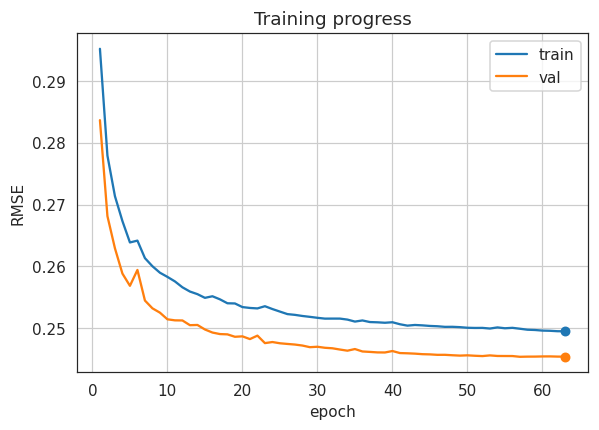

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2952 MAE=0.2311 R2=-0.0211 | "B": Acc=0.5083 Prec=0.2876 Rec=0.5030 F1=0.3660 AUROC=0.5087
VALID→ "R": RMSE=0.2836 MAE=0.2030 R2=0.0370 | "B": Acc=0.5390 Prec=0.3434 Rec=0.6166 F1=0.4412 AUROC=0.5835


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2779 MAE=0.2156 R2=0.0949 | "B": Acc=0.6081 Prec=0.3198 Rec=0.3454 F1=0.3322 AUROC=0.5459
VALID→ "R": RMSE=0.2681 MAE=0.2070 R2=0.1394 | "B": Acc=0.6220 Prec=0.3664 Rec=0.3853 F1=0.3756 AUROC=0.6025


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2714 MAE=0.2125 R2=0.1370 | "B": Acc=0.5984 Prec=0.2990 Rec=0.3151 F1=0.3069 AUROC=0.5199
VALID→ "R": RMSE=0.2629 MAE=0.2030 R2=0.1724 | "B": Acc=0.5624 Prec=0.3200 Rec=0.4292 F1=0.3666 AUROC=0.5465


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2673 MAE=0.2072 R2=0.1625 | "B": Acc=0.5754 Prec=0.2862 Rec=0.3379 F1=0.3099 AUROC=0.5048
VALID→ "R": RMSE=0.2588 MAE=0.1992 R2=0.1980 | "B": Acc=0.5835 Prec=0.3086 Rec=0.3316 F1=0.3197 AUROC=0.5324


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2639 MAE=0.2050 R2=0.1840 | "B": Acc=0.5715 Prec=0.2670 Rec=0.2974 F1=0.2814 AUROC=0.4789
VALID→ "R": RMSE=0.2569 MAE=0.1988 R2=0.2102 | "B": Acc=0.5744 Prec=0.2968 Rec=0.3228 F1=0.3092 AUROC=0.5083


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2642 MAE=0.2051 R2=0.1821 | "B": Acc=0.5759 Prec=0.2646 Rec=0.2828 F1=0.2734 AUROC=0.4718
VALID→ "R": RMSE=0.2594 MAE=0.1890 R2=0.1944 | "B": Acc=0.5457 Prec=0.3023 Rec=0.4125 F1=0.3490 AUROC=0.5165


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2613 MAE=0.2022 R2=0.1996 | "B": Acc=0.5618 Prec=0.2663 Rec=0.3152 F1=0.2887 AUROC=0.4759
VALID→ "R": RMSE=0.2545 MAE=0.1959 R2=0.2248 | "B": Acc=0.5532 Prec=0.2921 Rec=0.3611 F1=0.3229 AUROC=0.4975


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2600 MAE=0.2011 R2=0.2075 | "B": Acc=0.5593 Prec=0.2616 Rec=0.3084 F1=0.2831 AUROC=0.4655
VALID→ "R": RMSE=0.2532 MAE=0.1944 R2=0.2324 | "B": Acc=0.5483 Prec=0.2911 Rec=0.3697 F1=0.3257 AUROC=0.4923


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2590 MAE=0.1990 R2=0.2139 | "B": Acc=0.5465 Prec=0.2596 Rec=0.3281 F1=0.2898 AUROC=0.4606
VALID→ "R": RMSE=0.2525 MAE=0.1901 R2=0.2367 | "B": Acc=0.5401 Prec=0.2902 Rec=0.3862 F1=0.3314 AUROC=0.4866


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2583 MAE=0.1998 R2=0.2180 | "B": Acc=0.5659 Prec=0.2690 Rec=0.3137 F1=0.2897 AUROC=0.4704
VALID→ "R": RMSE=0.2514 MAE=0.1927 R2=0.2431 | "B": Acc=0.5439 Prec=0.2908 Rec=0.3793 F1=0.3292 AUROC=0.4854


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2576 MAE=0.1978 R2=0.2224 | "B": Acc=0.5554 Prec=0.2667 Rec=0.3292 F1=0.2947 AUROC=0.4680
VALID→ "R": RMSE=0.2513 MAE=0.1913 R2=0.2441 | "B": Acc=0.5191 Prec=0.2886 Rec=0.4295 F1=0.3452 AUROC=0.4852


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2566 MAE=0.1974 R2=0.2282 | "B": Acc=0.5602 Prec=0.2729 Rec=0.3358 F1=0.3011 AUROC=0.4742
VALID→ "R": RMSE=0.2513 MAE=0.1910 R2=0.2443 | "B": Acc=0.5077 Prec=0.2829 Rec=0.4356 F1=0.3431 AUROC=0.4727


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2559 MAE=0.1957 R2=0.2323 | "B": Acc=0.5706 Prec=0.2749 Rec=0.3188 F1=0.2952 AUROC=0.4737
VALID→ "R": RMSE=0.2505 MAE=0.1912 R2=0.2488 | "B": Acc=0.5238 Prec=0.2887 Rec=0.4192 F1=0.3419 AUROC=0.4766


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2555 MAE=0.1965 R2=0.2348 | "B": Acc=0.5622 Prec=0.2736 Rec=0.3332 F1=0.3005 AUROC=0.4718
VALID→ "R": RMSE=0.2505 MAE=0.1909 R2=0.2486 | "B": Acc=0.4866 Prec=0.2833 Rec=0.4837 F1=0.3574 AUROC=0.4749


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2549 MAE=0.1948 R2=0.2384 | "B": Acc=0.5634 Prec=0.2804 Rec=0.3494 F1=0.3111 AUROC=0.4809
VALID→ "R": RMSE=0.2498 MAE=0.1882 R2=0.2530 | "B": Acc=0.5059 Prec=0.2862 Rec=0.4512 F1=0.3502 AUROC=0.4775


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2552 MAE=0.1963 R2=0.2368 | "B": Acc=0.5513 Prec=0.2736 Rec=0.3568 F1=0.3097 AUROC=0.4740
VALID→ "R": RMSE=0.2493 MAE=0.1902 R2=0.2560 | "B": Acc=0.5100 Prec=0.2890 Rec=0.4523 F1=0.3527 AUROC=0.4773


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2547 MAE=0.1960 R2=0.2398 | "B": Acc=0.5567 Prec=0.2766 Rec=0.3538 F1=0.3105 AUROC=0.4764
VALID→ "R": RMSE=0.2491 MAE=0.1915 R2=0.2574 | "B": Acc=0.5082 Prec=0.2863 Rec=0.4465 F1=0.3489 AUROC=0.4710


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2540 MAE=0.1944 R2=0.2436 | "B": Acc=0.5606 Prec=0.2778 Rec=0.3484 F1=0.3091 AUROC=0.4764
VALID→ "R": RMSE=0.2490 MAE=0.1893 R2=0.2577 | "B": Acc=0.4929 Prec=0.2858 Rec=0.4792 F1=0.3581 AUROC=0.4760


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2540 MAE=0.1954 R2=0.2438 | "B": Acc=0.5634 Prec=0.2844 Rec=0.3612 F1=0.3183 AUROC=0.4860
VALID→ "R": RMSE=0.2486 MAE=0.1903 R2=0.2600 | "B": Acc=0.5051 Prec=0.2846 Rec=0.4472 F1=0.3478 AUROC=0.4685


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2534 MAE=0.1944 R2=0.2473 | "B": Acc=0.5576 Prec=0.2799 Rec=0.3614 F1=0.3155 AUROC=0.4805
VALID→ "R": RMSE=0.2487 MAE=0.1891 R2=0.2596 | "B": Acc=0.4956 Prec=0.2866 Rec=0.4763 F1=0.3579 AUROC=0.4753


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2533 MAE=0.1949 R2=0.2481 | "B": Acc=0.5613 Prec=0.2832 Rec=0.3623 F1=0.3179 AUROC=0.4839
VALID→ "R": RMSE=0.2483 MAE=0.1895 R2=0.2623 | "B": Acc=0.5129 Prec=0.2911 Rec=0.4531 F1=0.3544 AUROC=0.4792


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2532 MAE=0.1948 R2=0.2485 | "B": Acc=0.5670 Prec=0.2826 Rec=0.3476 F1=0.3117 AUROC=0.4831
VALID→ "R": RMSE=0.2488 MAE=0.1855 R2=0.2589 | "B": Acc=0.5499 Prec=0.3068 Rec=0.4169 F1=0.3535 AUROC=0.4966


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2536 MAE=0.1946 R2=0.2464 | "B": Acc=0.5746 Prec=0.2845 Rec=0.3352 F1=0.3078 AUROC=0.4842
VALID→ "R": RMSE=0.2476 MAE=0.1892 R2=0.2661 | "B": Acc=0.5386 Prec=0.2989 Rec=0.4187 F1=0.3488 AUROC=0.4839


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2531 MAE=0.1944 R2=0.2492 | "B": Acc=0.5696 Prec=0.2825 Rec=0.3414 F1=0.3092 AUROC=0.4804
VALID→ "R": RMSE=0.2478 MAE=0.1900 R2=0.2651 | "B": Acc=0.5251 Prec=0.2952 Rec=0.4389 F1=0.3530 AUROC=0.4791


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2527 MAE=0.1938 R2=0.2516 | "B": Acc=0.5692 Prec=0.2853 Rec=0.3503 F1=0.3145 AUROC=0.4844
VALID→ "R": RMSE=0.2476 MAE=0.1894 R2=0.2663 | "B": Acc=0.5231 Prec=0.2961 Rec=0.4473 F1=0.3563 AUROC=0.4833


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2523 MAE=0.1938 R2=0.2540 | "B": Acc=0.5707 Prec=0.2872 Rec=0.3521 F1=0.3163 AUROC=0.4880
VALID→ "R": RMSE=0.2475 MAE=0.1890 R2=0.2669 | "B": Acc=0.5418 Prec=0.3023 Rec=0.4225 F1=0.3524 AUROC=0.4854


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2522 MAE=0.1936 R2=0.2547 | "B": Acc=0.5731 Prec=0.2850 Rec=0.3402 F1=0.3102 AUROC=0.4831
VALID→ "R": RMSE=0.2474 MAE=0.1888 R2=0.2675 | "B": Acc=0.5439 Prec=0.3032 Rec=0.4202 F1=0.3522 AUROC=0.4861


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2520 MAE=0.1931 R2=0.2558 | "B": Acc=0.5729 Prec=0.2874 Rec=0.3472 F1=0.3145 AUROC=0.4872
VALID→ "R": RMSE=0.2472 MAE=0.1885 R2=0.2684 | "B": Acc=0.5400 Prec=0.3031 Rec=0.4299 F1=0.3555 AUROC=0.4871


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2518 MAE=0.1929 R2=0.2566 | "B": Acc=0.5736 Prec=0.2885 Rec=0.3489 F1=0.3158 AUROC=0.4891
VALID→ "R": RMSE=0.2469 MAE=0.1887 R2=0.2700 | "B": Acc=0.5387 Prec=0.3037 Rec=0.4357 F1=0.3579 AUROC=0.4880


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2517 MAE=0.1927 R2=0.2575 | "B": Acc=0.5685 Prec=0.2872 Rec=0.3572 F1=0.3184 AUROC=0.4883
VALID→ "R": RMSE=0.2470 MAE=0.1885 R2=0.2696 | "B": Acc=0.5388 Prec=0.3034 Rec=0.4342 F1=0.3572 AUROC=0.4851


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2516 MAE=0.1927 R2=0.2583 | "B": Acc=0.5745 Prec=0.2893 Rec=0.3490 F1=0.3164 AUROC=0.4897
VALID→ "R": RMSE=0.2468 MAE=0.1883 R2=0.2706 | "B": Acc=0.5459 Prec=0.3064 Rec=0.4265 F1=0.3566 AUROC=0.4875


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2516 MAE=0.1927 R2=0.2583 | "B": Acc=0.5709 Prec=0.2868 Rec=0.3503 F1=0.3154 AUROC=0.4871
VALID→ "R": RMSE=0.2468 MAE=0.1883 R2=0.2711 | "B": Acc=0.5432 Prec=0.3046 Rec=0.4270 F1=0.3555 AUROC=0.4838


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2516 MAE=0.1928 R2=0.2583 | "B": Acc=0.5663 Prec=0.2847 Rec=0.3553 F1=0.3161 AUROC=0.4854
VALID→ "R": RMSE=0.2466 MAE=0.1892 R2=0.2723 | "B": Acc=0.5374 Prec=0.3027 Rec=0.4354 F1=0.3571 AUROC=0.4844


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2514 MAE=0.1926 R2=0.2592 | "B": Acc=0.5652 Prec=0.2850 Rec=0.3588 F1=0.3177 AUROC=0.4860
VALID→ "R": RMSE=0.2464 MAE=0.1884 R2=0.2734 | "B": Acc=0.5550 Prec=0.3075 Rec=0.4056 F1=0.3498 AUROC=0.4844


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2511 MAE=0.1922 R2=0.2611 | "B": Acc=0.5661 Prec=0.2829 Rec=0.3503 F1=0.3130 AUROC=0.4825
VALID→ "R": RMSE=0.2466 MAE=0.1881 R2=0.2718 | "B": Acc=0.5542 Prec=0.3086 Rec=0.4117 F1=0.3528 AUROC=0.4860


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2513 MAE=0.1927 R2=0.2601 | "B": Acc=0.5644 Prec=0.2836 Rec=0.3566 F1=0.3160 AUROC=0.4856
VALID→ "R": RMSE=0.2463 MAE=0.1889 R2=0.2741 | "B": Acc=0.5477 Prec=0.3067 Rec=0.4226 F1=0.3554 AUROC=0.4909


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2510 MAE=0.1920 R2=0.2616 | "B": Acc=0.5682 Prec=0.2859 Rec=0.3540 F1=0.3163 AUROC=0.4884
VALID→ "R": RMSE=0.2462 MAE=0.1882 R2=0.2745 | "B": Acc=0.5542 Prec=0.3087 Rec=0.4118 F1=0.3528 AUROC=0.4883


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2510 MAE=0.1921 R2=0.2618 | "B": Acc=0.5713 Prec=0.2862 Rec=0.3476 F1=0.3139 AUROC=0.4859
VALID→ "R": RMSE=0.2461 MAE=0.1882 R2=0.2750 | "B": Acc=0.5560 Prec=0.3102 Rec=0.4122 F1=0.3540 AUROC=0.4915


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2509 MAE=0.1920 R2=0.2622 | "B": Acc=0.5678 Prec=0.2857 Rec=0.3546 F1=0.3165 AUROC=0.4872
VALID→ "R": RMSE=0.2461 MAE=0.1880 R2=0.2751 | "B": Acc=0.5593 Prec=0.3120 Rec=0.4092 F1=0.3540 AUROC=0.4938


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2510 MAE=0.1924 R2=0.2618 | "B": Acc=0.5760 Prec=0.2894 Rec=0.3455 F1=0.3150 AUROC=0.4906
VALID→ "R": RMSE=0.2463 MAE=0.1890 R2=0.2737 | "B": Acc=0.5740 Prec=0.3180 Rec=0.3873 F1=0.3492 AUROC=0.4918


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2507 MAE=0.1919 R2=0.2637 | "B": Acc=0.5761 Prec=0.2874 Rec=0.3396 F1=0.3113 AUROC=0.4872
VALID→ "R": RMSE=0.2460 MAE=0.1881 R2=0.2756 | "B": Acc=0.5712 Prec=0.3186 Rec=0.3977 F1=0.3538 AUROC=0.4976


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2504 MAE=0.1912 R2=0.2650 | "B": Acc=0.5825 Prec=0.2932 Rec=0.3402 F1=0.3149 AUROC=0.4945
VALID→ "R": RMSE=0.2460 MAE=0.1877 R2=0.2758 | "B": Acc=0.5805 Prec=0.3240 Rec=0.3881 F1=0.3532 AUROC=0.5024


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2505 MAE=0.1916 R2=0.2643 | "B": Acc=0.5818 Prec=0.2908 Rec=0.3351 F1=0.3114 AUROC=0.4904
VALID→ "R": RMSE=0.2459 MAE=0.1878 R2=0.2762 | "B": Acc=0.5786 Prec=0.3232 Rec=0.3911 F1=0.3539 AUROC=0.5027


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2505 MAE=0.1914 R2=0.2647 | "B": Acc=0.5791 Prec=0.2900 Rec=0.3395 F1=0.3128 AUROC=0.4907
VALID→ "R": RMSE=0.2458 MAE=0.1880 R2=0.2767 | "B": Acc=0.5749 Prec=0.3211 Rec=0.3952 F1=0.3543 AUROC=0.5013


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2504 MAE=0.1913 R2=0.2653 | "B": Acc=0.5801 Prec=0.2917 Rec=0.3419 F1=0.3148 AUROC=0.4932
VALID→ "R": RMSE=0.2458 MAE=0.1881 R2=0.2769 | "B": Acc=0.5839 Prec=0.3258 Rec=0.3834 F1=0.3522 AUROC=0.5023


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2503 MAE=0.1911 R2=0.2656 | "B": Acc=0.5851 Prec=0.2919 Rec=0.3302 F1=0.3099 AUROC=0.4918
VALID→ "R": RMSE=0.2457 MAE=0.1881 R2=0.2773 | "B": Acc=0.5830 Prec=0.3248 Rec=0.3828 F1=0.3514 AUROC=0.5017


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2502 MAE=0.1910 R2=0.2661 | "B": Acc=0.5802 Prec=0.2900 Rec=0.3370 F1=0.3117 AUROC=0.4910
VALID→ "R": RMSE=0.2457 MAE=0.1878 R2=0.2773 | "B": Acc=0.5765 Prec=0.3225 Rec=0.3952 F1=0.3552 AUROC=0.5033


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2502 MAE=0.1909 R2=0.2661 | "B": Acc=0.5793 Prec=0.2908 Rec=0.3411 F1=0.3139 AUROC=0.4923
VALID→ "R": RMSE=0.2456 MAE=0.1873 R2=0.2777 | "B": Acc=0.5825 Prec=0.3257 Rec=0.3876 F1=0.3540 AUROC=0.5049


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2502 MAE=0.1908 R2=0.2664 | "B": Acc=0.5745 Prec=0.2872 Rec=0.3429 F1=0.3126 AUROC=0.4894
VALID→ "R": RMSE=0.2456 MAE=0.1874 R2=0.2780 | "B": Acc=0.5746 Prec=0.3222 Rec=0.4001 F1=0.3569 AUROC=0.5045


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2501 MAE=0.1908 R2=0.2670 | "B": Acc=0.5825 Prec=0.2913 Rec=0.3350 F1=0.3116 AUROC=0.4936
VALID→ "R": RMSE=0.2456 MAE=0.1872 R2=0.2778 | "B": Acc=0.5902 Prec=0.3310 Rec=0.3807 F1=0.3541 AUROC=0.5090


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2501 MAE=0.1909 R2=0.2672 | "B": Acc=0.5889 Prec=0.2947 Rec=0.3283 F1=0.3106 AUROC=0.4963
VALID→ "R": RMSE=0.2456 MAE=0.1872 R2=0.2782 | "B": Acc=0.5887 Prec=0.3306 Rec=0.3842 F1=0.3554 AUROC=0.5094


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2501 MAE=0.1909 R2=0.2671 | "B": Acc=0.5854 Prec=0.2937 Rec=0.3342 F1=0.3127 AUROC=0.4957
VALID→ "R": RMSE=0.2455 MAE=0.1873 R2=0.2785 | "B": Acc=0.5858 Prec=0.3288 Rec=0.3875 F1=0.3558 AUROC=0.5094


Epoch 53:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2500 MAE=0.1909 R2=0.2677 | "B": Acc=0.5822 Prec=0.2906 Rec=0.3338 F1=0.3107 AUROC=0.4923
VALID→ "R": RMSE=0.2456 MAE=0.1864 R2=0.2778 | "B": Acc=0.5856 Prec=0.3295 Rec=0.3905 F1=0.3574 AUROC=0.5111


Epoch 54:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2501 MAE=0.1908 R2=0.2667 | "B": Acc=0.5905 Prec=0.2944 Rec=0.3231 F1=0.3081 AUROC=0.4950
VALID→ "R": RMSE=0.2455 MAE=0.1865 R2=0.2784 | "B": Acc=0.5909 Prec=0.3328 Rec=0.3842 F1=0.3566 AUROC=0.5124


Epoch 55:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 055
TRAIN→ "R": RMSE=0.2500 MAE=0.1908 R2=0.2675 | "B": Acc=0.5941 Prec=0.2963 Rec=0.3191 F1=0.3072 AUROC=0.4965
VALID→ "R": RMSE=0.2455 MAE=0.1855 R2=0.2784 | "B": Acc=0.5963 Prec=0.3371 Rec=0.3809 F1=0.3576 AUROC=0.5186


Epoch 56:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 056
TRAIN→ "R": RMSE=0.2501 MAE=0.1904 R2=0.2671 | "B": Acc=0.6004 Prec=0.2984 Rec=0.3081 F1=0.3032 AUROC=0.4983
VALID→ "R": RMSE=0.2455 MAE=0.1854 R2=0.2784 | "B": Acc=0.5967 Prec=0.3382 Rec=0.3832 F1=0.3593 AUROC=0.5221


Epoch 57:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 057
TRAIN→ "R": RMSE=0.2499 MAE=0.1904 R2=0.2679 | "B": Acc=0.6006 Prec=0.2995 Rec=0.3104 F1=0.3048 AUROC=0.5002
VALID→ "R": RMSE=0.2454 MAE=0.1858 R2=0.2792 | "B": Acc=0.5986 Prec=0.3385 Rec=0.3777 F1=0.3570 AUROC=0.5197


Epoch 58:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 058
TRAIN→ "R": RMSE=0.2498 MAE=0.1904 R2=0.2688 | "B": Acc=0.5991 Prec=0.2977 Rec=0.3098 F1=0.3037 AUROC=0.4968
VALID→ "R": RMSE=0.2454 MAE=0.1859 R2=0.2790 | "B": Acc=0.5971 Prec=0.3376 Rec=0.3795 F1=0.3573 AUROC=0.5188


Epoch 59:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 059
TRAIN→ "R": RMSE=0.2497 MAE=0.1905 R2=0.2691 | "B": Acc=0.6014 Prec=0.2994 Rec=0.3080 F1=0.3036 AUROC=0.4986
VALID→ "R": RMSE=0.2454 MAE=0.1861 R2=0.2790 | "B": Acc=0.5969 Prec=0.3366 Rec=0.3768 F1=0.3556 AUROC=0.5169


Epoch 60:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 060
TRAIN→ "R": RMSE=0.2496 MAE=0.1904 R2=0.2697 | "B": Acc=0.6000 Prec=0.2980 Rec=0.3083 F1=0.3031 AUROC=0.4976
VALID→ "R": RMSE=0.2454 MAE=0.1858 R2=0.2788 | "B": Acc=0.6013 Prec=0.3390 Rec=0.3695 F1=0.3536 AUROC=0.5173


Epoch 61:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 061
TRAIN→ "R": RMSE=0.2496 MAE=0.1903 R2=0.2699 | "B": Acc=0.6030 Prec=0.2996 Rec=0.3043 F1=0.3019 AUROC=0.4979
VALID→ "R": RMSE=0.2455 MAE=0.1857 R2=0.2788 | "B": Acc=0.6018 Prec=0.3392 Rec=0.3686 F1=0.3533 AUROC=0.5175


Epoch 62:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 062
TRAIN→ "R": RMSE=0.2495 MAE=0.1902 R2=0.2703 | "B": Acc=0.6027 Prec=0.2985 Rec=0.3024 F1=0.3005 AUROC=0.4972
VALID→ "R": RMSE=0.2454 MAE=0.1854 R2=0.2790 | "B": Acc=0.6041 Prec=0.3407 Rec=0.3650 F1=0.3524 AUROC=0.5183


Epoch 63:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 063
TRAIN→ "R": RMSE=0.2495 MAE=0.1900 R2=0.2703 | "B": Acc=0.6031 Prec=0.2982 Rec=0.3006 F1=0.2994 AUROC=0.4973
VALID→ "R": RMSE=0.2454 MAE=0.1852 R2=0.2791 | "B": Acc=0.6043 Prec=0.3409 Rec=0.3651 F1=0.3526 AUROC=0.5200
Early stopping at epoch 63
✅ Final best model (_fin) saved: AAPL_0.24539_fin.pth
Delete variables to free memory...


[I 2025-09-18 23:57:00,347] Trial 6 finished with value: 0.24539156258106232 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.2086838074101272, 'DROPOUT_LONG': 0.19690314163834932, 'ATT_DROPOUT': 0.1484913607353128, 'INITIAL_LR': 0.00015126864569891505, 'ETA_MIN': 1.9154179390836075e-06, 'WEIGHT_DECAY': 0.006780148607218449, 'CLIPNORM': 0.8611423241893662}. Best is trial 1 with value: 0.24039407074451447.



▶ Trial 7 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.1787565960923505, 'DROPOUT_LONG': 0.14406351384529117, 'ATT_DROPOUT': 0.23839143702023868, 'INITIAL_LR': 0.0002423444558071115, 'ETA_MIN': 5.715324128122348e-06, 'WEIGHT_DECAY': 6.635037713770273e-05, 'CLIPNORM': 5.853137941834936}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['adx_14', 'atr_14', 'ret', 'atr_pct_14', 'log_ret', 'macd_signal_12_26_9', 'bb_hband_20', 'body', 'bb_w_20', 'eng_vwap', 'minus_di_14', 'body_pct', 'hour', 'eng_obv', 'vol_spike_14', 'macd_diff_12_26_9', 'sma_28', 'eng_sma_long', 'obv_pct_14', 'eng_macd']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


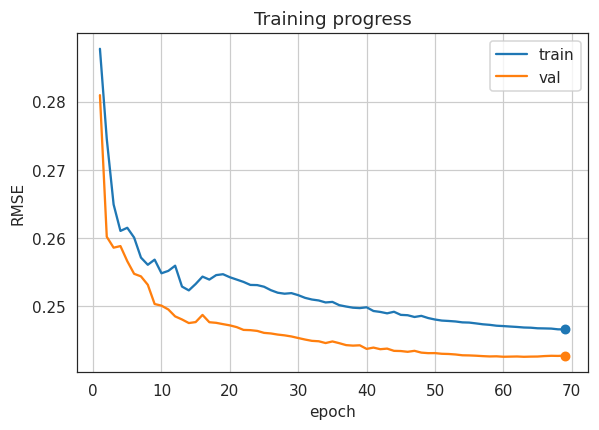

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2877 MAE=0.2245 R2=0.0189 | "B": Acc=0.3691 Prec=0.2822 Rec=0.8296 F1=0.4211 AUROC=0.5286
VALID→ "R": RMSE=0.2809 MAE=0.1971 R2=0.0419 | "B": Acc=0.4808 Prec=0.2923 Rec=0.5681 F1=0.3860 AUROC=0.5121


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2745 MAE=0.2115 R2=0.1068 | "B": Acc=0.4605 Prec=0.2901 Rec=0.6566 F1=0.4024 AUROC=0.5305
VALID→ "R": RMSE=0.2602 MAE=0.2012 R2=0.1781 | "B": Acc=0.6328 Prec=0.3506 Rec=0.3265 F1=0.3381 AUROC=0.5595


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2649 MAE=0.2037 R2=0.1681 | "B": Acc=0.5159 Prec=0.2894 Rec=0.5155 F1=0.3707 AUROC=0.5212
VALID→ "R": RMSE=0.2586 MAE=0.1996 R2=0.1882 | "B": Acc=0.6465 Prec=0.3286 Rec=0.2210 F1=0.2642 AUROC=0.5166


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2611 MAE=0.2005 R2=0.1923 | "B": Acc=0.5394 Prec=0.2809 Rec=0.4262 F1=0.3386 AUROC=0.5043
VALID→ "R": RMSE=0.2588 MAE=0.1897 R2=0.1867 | "B": Acc=0.6443 Prec=0.2856 Rec=0.1584 F1=0.2038 AUROC=0.4710


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2615 MAE=0.2005 R2=0.1894 | "B": Acc=0.5646 Prec=0.2772 Rec=0.3571 F1=0.3121 AUROC=0.4969
VALID→ "R": RMSE=0.2566 MAE=0.1929 R2=0.2005 | "B": Acc=0.6520 Prec=0.2477 Rec=0.1036 F1=0.1461 AUROC=0.4597


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2601 MAE=0.1997 R2=0.1983 | "B": Acc=0.5584 Prec=0.2671 Rec=0.3420 F1=0.2999 AUROC=0.4826
VALID→ "R": RMSE=0.2548 MAE=0.1893 R2=0.2120 | "B": Acc=0.6393 Prec=0.2761 Rec=0.1574 F1=0.2005 AUROC=0.4424


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2572 MAE=0.1969 R2=0.2163 | "B": Acc=0.5511 Prec=0.2649 Rec=0.3510 F1=0.3019 AUROC=0.4784
VALID→ "R": RMSE=0.2544 MAE=0.1855 R2=0.2143 | "B": Acc=0.6387 Prec=0.2494 Rec=0.1281 F1=0.1693 AUROC=0.4173


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2561 MAE=0.1957 R2=0.2227 | "B": Acc=0.5460 Prec=0.2493 Rec=0.3188 F1=0.2798 AUROC=0.4575
VALID→ "R": RMSE=0.2532 MAE=0.1841 R2=0.2219 | "B": Acc=0.6250 Prec=0.2573 Rec=0.1617 F1=0.1986 AUROC=0.4162


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2569 MAE=0.1959 R2=0.2181 | "B": Acc=0.5314 Prec=0.2445 Rec=0.3319 F1=0.2815 AUROC=0.4498
VALID→ "R": RMSE=0.2504 MAE=0.1905 R2=0.2391 | "B": Acc=0.6188 Prec=0.2622 Rec=0.1802 F1=0.2136 AUROC=0.4273


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2549 MAE=0.1952 R2=0.2302 | "B": Acc=0.5315 Prec=0.2420 Rec=0.3252 F1=0.2775 AUROC=0.4477
VALID→ "R": RMSE=0.2501 MAE=0.1840 R2=0.2406 | "B": Acc=0.5824 Prec=0.2575 Rec=0.2408 F1=0.2489 AUROC=0.4237


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2552 MAE=0.1952 R2=0.2281 | "B": Acc=0.5562 Prec=0.2509 Rec=0.3042 F1=0.2750 AUROC=0.4588
VALID→ "R": RMSE=0.2496 MAE=0.1939 R2=0.2440 | "B": Acc=0.6177 Prec=0.2743 Rec=0.2010 F1=0.2320 AUROC=0.4461


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2560 MAE=0.1975 R2=0.2235 | "B": Acc=0.5418 Prec=0.2479 Rec=0.3226 F1=0.2804 AUROC=0.4538
VALID→ "R": RMSE=0.2485 MAE=0.1855 R2=0.2501 | "B": Acc=0.5732 Prec=0.2669 Rec=0.2781 F1=0.2724 AUROC=0.4369


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2529 MAE=0.1926 R2=0.2419 | "B": Acc=0.5331 Prec=0.2452 Rec=0.3308 F1=0.2816 AUROC=0.4500
VALID→ "R": RMSE=0.2481 MAE=0.1875 R2=0.2528 | "B": Acc=0.5597 Prec=0.2703 Rec=0.3133 F1=0.2902 AUROC=0.4479


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2524 MAE=0.1921 R2=0.2453 | "B": Acc=0.5511 Prec=0.2425 Rec=0.2932 F1=0.2655 AUROC=0.4457
VALID→ "R": RMSE=0.2476 MAE=0.1862 R2=0.2560 | "B": Acc=0.5761 Prec=0.2758 Rec=0.2924 F1=0.2838 AUROC=0.4505


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2533 MAE=0.1938 R2=0.2396 | "B": Acc=0.5525 Prec=0.2503 Rec=0.3097 F1=0.2768 AUROC=0.4544
VALID→ "R": RMSE=0.2477 MAE=0.1857 R2=0.2551 | "B": Acc=0.5402 Prec=0.2881 Rec=0.4080 F1=0.3377 AUROC=0.4812


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2544 MAE=0.1946 R2=0.2331 | "B": Acc=0.5639 Prec=0.2600 Rec=0.3122 F1=0.2837 AUROC=0.4672
VALID→ "R": RMSE=0.2488 MAE=0.1912 R2=0.2488 | "B": Acc=0.5917 Prec=0.2900 Rec=0.2907 F1=0.2903 AUROC=0.4660


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2539 MAE=0.1941 R2=0.2358 | "B": Acc=0.5648 Prec=0.2537 Rec=0.2951 F1=0.2728 AUROC=0.4579
VALID→ "R": RMSE=0.2477 MAE=0.1841 R2=0.2552 | "B": Acc=0.5693 Prec=0.2835 Rec=0.3267 F1=0.3035 AUROC=0.4630


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2546 MAE=0.1942 R2=0.2318 | "B": Acc=0.5537 Prec=0.2514 Rec=0.3100 F1=0.2776 AUROC=0.4551
VALID→ "R": RMSE=0.2476 MAE=0.1831 R2=0.2558 | "B": Acc=0.5569 Prec=0.2831 Rec=0.3540 F1=0.3146 AUROC=0.4677


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2547 MAE=0.1946 R2=0.2310 | "B": Acc=0.5560 Prec=0.2535 Rec=0.3110 F1=0.2793 AUROC=0.4570
VALID→ "R": RMSE=0.2474 MAE=0.1844 R2=0.2569 | "B": Acc=0.5704 Prec=0.2810 Rec=0.3177 F1=0.2982 AUROC=0.4676


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2543 MAE=0.1943 R2=0.2337 | "B": Acc=0.5537 Prec=0.2541 Rec=0.3170 F1=0.2821 AUROC=0.4587
VALID→ "R": RMSE=0.2472 MAE=0.1841 R2=0.2580 | "B": Acc=0.5620 Prec=0.2798 Rec=0.3332 F1=0.3042 AUROC=0.4703


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2539 MAE=0.1941 R2=0.2358 | "B": Acc=0.5515 Prec=0.2561 Rec=0.3263 F1=0.2870 AUROC=0.4619
VALID→ "R": RMSE=0.2470 MAE=0.1841 R2=0.2595 | "B": Acc=0.5481 Prec=0.2832 Rec=0.3741 F1=0.3224 AUROC=0.4795


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2536 MAE=0.1937 R2=0.2378 | "B": Acc=0.5451 Prec=0.2572 Rec=0.3412 F1=0.2933 AUROC=0.4657
VALID→ "R": RMSE=0.2466 MAE=0.1853 R2=0.2620 | "B": Acc=0.5296 Prec=0.2830 Rec=0.4157 F1=0.3368 AUROC=0.4850


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2531 MAE=0.1930 R2=0.2405 | "B": Acc=0.5310 Prec=0.2576 Rec=0.3695 F1=0.3036 AUROC=0.4670
VALID→ "R": RMSE=0.2465 MAE=0.1838 R2=0.2622 | "B": Acc=0.5417 Prec=0.2844 Rec=0.3925 F1=0.3298 AUROC=0.4844


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2531 MAE=0.1933 R2=0.2406 | "B": Acc=0.5389 Prec=0.2595 Rec=0.3597 F1=0.3015 AUROC=0.4695
VALID→ "R": RMSE=0.2464 MAE=0.1835 R2=0.2629 | "B": Acc=0.5300 Prec=0.2855 Rec=0.4232 F1=0.3410 AUROC=0.4888


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2529 MAE=0.1931 R2=0.2421 | "B": Acc=0.5240 Prec=0.2575 Rec=0.3828 F1=0.3079 AUROC=0.4682
VALID→ "R": RMSE=0.2461 MAE=0.1835 R2=0.2646 | "B": Acc=0.5011 Prec=0.2823 Rec=0.4778 F1=0.3549 AUROC=0.4919


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2524 MAE=0.1924 R2=0.2451 | "B": Acc=0.5171 Prec=0.2609 Rec=0.4069 F1=0.3180 AUROC=0.4742
VALID→ "R": RMSE=0.2460 MAE=0.1839 R2=0.2651 | "B": Acc=0.5126 Prec=0.2819 Rec=0.4502 F1=0.3467 AUROC=0.4872


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2520 MAE=0.1922 R2=0.2473 | "B": Acc=0.5220 Prec=0.2603 Rec=0.3954 F1=0.3139 AUROC=0.4732
VALID→ "R": RMSE=0.2459 MAE=0.1841 R2=0.2661 | "B": Acc=0.5304 Prec=0.2863 Rec=0.4250 F1=0.3421 AUROC=0.4898


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2519 MAE=0.1921 R2=0.2482 | "B": Acc=0.5237 Prec=0.2617 Rec=0.3965 F1=0.3153 AUROC=0.4747
VALID→ "R": RMSE=0.2458 MAE=0.1833 R2=0.2668 | "B": Acc=0.5227 Prec=0.2912 Rec=0.4610 F1=0.3569 AUROC=0.5005


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2519 MAE=0.1924 R2=0.2477 | "B": Acc=0.5227 Prec=0.2653 Rec=0.4099 F1=0.3221 AUROC=0.4809
VALID→ "R": RMSE=0.2456 MAE=0.1828 R2=0.2677 | "B": Acc=0.5101 Prec=0.2891 Rec=0.4833 F1=0.3617 AUROC=0.5011


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2517 MAE=0.1921 R2=0.2494 | "B": Acc=0.5199 Prec=0.2641 Rec=0.4117 F1=0.3218 AUROC=0.4799
VALID→ "R": RMSE=0.2454 MAE=0.1832 R2=0.2691 | "B": Acc=0.5104 Prec=0.2879 Rec=0.4776 F1=0.3592 AUROC=0.4993


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2513 MAE=0.1918 R2=0.2518 | "B": Acc=0.5198 Prec=0.2645 Rec=0.4131 F1=0.3225 AUROC=0.4811
VALID→ "R": RMSE=0.2452 MAE=0.1835 R2=0.2704 | "B": Acc=0.5033 Prec=0.2856 Rec=0.4856 F1=0.3597 AUROC=0.4982


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2510 MAE=0.1916 R2=0.2532 | "B": Acc=0.5151 Prec=0.2656 Rec=0.4267 F1=0.3274 AUROC=0.4831
VALID→ "R": RMSE=0.2450 MAE=0.1837 R2=0.2715 | "B": Acc=0.4949 Prec=0.2837 Rec=0.4975 F1=0.3614 AUROC=0.4972


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2509 MAE=0.1916 R2=0.2541 | "B": Acc=0.5184 Prec=0.2679 Rec=0.4275 F1=0.3294 AUROC=0.4863
VALID→ "R": RMSE=0.2449 MAE=0.1831 R2=0.2719 | "B": Acc=0.5063 Prec=0.2830 Rec=0.4684 F1=0.3528 AUROC=0.4924


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2506 MAE=0.1911 R2=0.2558 | "B": Acc=0.5184 Prec=0.2635 Rec=0.4127 F1=0.3216 AUROC=0.4788
VALID→ "R": RMSE=0.2446 MAE=0.1845 R2=0.2735 | "B": Acc=0.4994 Prec=0.2823 Rec=0.4814 F1=0.3559 AUROC=0.4929


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2507 MAE=0.1915 R2=0.2553 | "B": Acc=0.5143 Prec=0.2655 Rec=0.4278 F1=0.3276 AUROC=0.4823
VALID→ "R": RMSE=0.2449 MAE=0.1820 R2=0.2721 | "B": Acc=0.4924 Prec=0.2821 Rec=0.4964 F1=0.3598 AUROC=0.4936


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2502 MAE=0.1903 R2=0.2581 | "B": Acc=0.5112 Prec=0.2633 Rec=0.4265 F1=0.3256 AUROC=0.4792
VALID→ "R": RMSE=0.2446 MAE=0.1816 R2=0.2736 | "B": Acc=0.4757 Prec=0.2803 Rec=0.5261 F1=0.3657 AUROC=0.4947


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2500 MAE=0.1902 R2=0.2593 | "B": Acc=0.5064 Prec=0.2636 Rec=0.4372 F1=0.3289 AUROC=0.4804
VALID→ "R": RMSE=0.2443 MAE=0.1834 R2=0.2753 | "B": Acc=0.4912 Prec=0.2811 Rec=0.4953 F1=0.3587 AUROC=0.4934


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2498 MAE=0.1900 R2=0.2603 | "B": Acc=0.5143 Prec=0.2642 Rec=0.4234 F1=0.3254 AUROC=0.4806
VALID→ "R": RMSE=0.2443 MAE=0.1833 R2=0.2757 | "B": Acc=0.5048 Prec=0.2839 Rec=0.4752 F1=0.3554 AUROC=0.4956


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2498 MAE=0.1900 R2=0.2607 | "B": Acc=0.5188 Prec=0.2651 Rec=0.4172 F1=0.3242 AUROC=0.4820
VALID→ "R": RMSE=0.2443 MAE=0.1822 R2=0.2754 | "B": Acc=0.4933 Prec=0.2845 Rec=0.5042 F1=0.3637 AUROC=0.4989


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2499 MAE=0.1896 R2=0.2600 | "B": Acc=0.5176 Prec=0.2640 Rec=0.4161 F1=0.3231 AUROC=0.4813
VALID→ "R": RMSE=0.2438 MAE=0.1847 R2=0.2785 | "B": Acc=0.4968 Prec=0.2878 Rec=0.5096 F1=0.3679 AUROC=0.5048


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2493 MAE=0.1897 R2=0.2632 | "B": Acc=0.5146 Prec=0.2690 Rec=0.4394 F1=0.3337 AUROC=0.4888
VALID→ "R": RMSE=0.2440 MAE=0.1829 R2=0.2774 | "B": Acc=0.5085 Prec=0.2911 Rec=0.4954 F1=0.3667 AUROC=0.5079


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2492 MAE=0.1891 R2=0.2640 | "B": Acc=0.5181 Prec=0.2669 Rec=0.4247 F1=0.3278 AUROC=0.4854
VALID→ "R": RMSE=0.2437 MAE=0.1836 R2=0.2788 | "B": Acc=0.4933 Prec=0.2879 Rec=0.5185 F1=0.3703 AUROC=0.5063


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2490 MAE=0.1894 R2=0.2652 | "B": Acc=0.5136 Prec=0.2681 Rec=0.4381 F1=0.3326 AUROC=0.4878
VALID→ "R": RMSE=0.2438 MAE=0.1822 R2=0.2783 | "B": Acc=0.4970 Prec=0.2905 Rec=0.5207 F1=0.3729 AUROC=0.5097


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2492 MAE=0.1892 R2=0.2639 | "B": Acc=0.5158 Prec=0.2656 Rec=0.4250 F1=0.3269 AUROC=0.4836
VALID→ "R": RMSE=0.2435 MAE=0.1834 R2=0.2802 | "B": Acc=0.4899 Prec=0.2914 Rec=0.5417 F1=0.3789 AUROC=0.5149


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2488 MAE=0.1888 R2=0.2665 | "B": Acc=0.5259 Prec=0.2719 Rec=0.4254 F1=0.3318 AUROC=0.4935
VALID→ "R": RMSE=0.2435 MAE=0.1832 R2=0.2804 | "B": Acc=0.4980 Prec=0.2918 Rec=0.5238 F1=0.3748 AUROC=0.5127


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2487 MAE=0.1886 R2=0.2668 | "B": Acc=0.5213 Prec=0.2694 Rec=0.4267 F1=0.3303 AUROC=0.4901
VALID→ "R": RMSE=0.2434 MAE=0.1837 R2=0.2811 | "B": Acc=0.5027 Prec=0.2969 Rec=0.5345 F1=0.3818 AUROC=0.5229


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2485 MAE=0.1887 R2=0.2684 | "B": Acc=0.5201 Prec=0.2721 Rec=0.4387 F1=0.3359 AUROC=0.4944
VALID→ "R": RMSE=0.2435 MAE=0.1824 R2=0.2802 | "B": Acc=0.5013 Prec=0.2958 Rec=0.5330 F1=0.3805 AUROC=0.5209


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2486 MAE=0.1888 R2=0.2674 | "B": Acc=0.5226 Prec=0.2711 Rec=0.4297 F1=0.3324 AUROC=0.4932
VALID→ "R": RMSE=0.2432 MAE=0.1830 R2=0.2818 | "B": Acc=0.5116 Prec=0.2998 Rec=0.5240 F1=0.3814 AUROC=0.5253


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2483 MAE=0.1885 R2=0.2693 | "B": Acc=0.5288 Prec=0.2718 Rec=0.4186 F1=0.3296 AUROC=0.4935
VALID→ "R": RMSE=0.2432 MAE=0.1834 R2=0.2822 | "B": Acc=0.5106 Prec=0.3013 Rec=0.5333 F1=0.3850 AUROC=0.5295


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2481 MAE=0.1882 R2=0.2706 | "B": Acc=0.5313 Prec=0.2745 Rec=0.4226 F1=0.3328 AUROC=0.4978
VALID→ "R": RMSE=0.2432 MAE=0.1837 R2=0.2822 | "B": Acc=0.5257 Prec=0.3066 Rec=0.5162 F1=0.3847 AUROC=0.5345


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2479 MAE=0.1883 R2=0.2715 | "B": Acc=0.5293 Prec=0.2742 Rec=0.4258 F1=0.3336 AUROC=0.4980
VALID→ "R": RMSE=0.2431 MAE=0.1832 R2=0.2828 | "B": Acc=0.5214 Prec=0.3053 Rec=0.5222 F1=0.3853 AUROC=0.5337


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2479 MAE=0.1881 R2=0.2718 | "B": Acc=0.5313 Prec=0.2745 Rec=0.4223 F1=0.3327 AUROC=0.4984
VALID→ "R": RMSE=0.2430 MAE=0.1837 R2=0.2829 | "B": Acc=0.5184 Prec=0.3087 Rec=0.5456 F1=0.3943 AUROC=0.5434


Epoch 53:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2478 MAE=0.1881 R2=0.2722 | "B": Acc=0.5292 Prec=0.2778 Rec=0.4387 F1=0.3402 AUROC=0.5046
VALID→ "R": RMSE=0.2430 MAE=0.1836 R2=0.2834 | "B": Acc=0.5155 Prec=0.3063 Rec=0.5428 F1=0.3916 AUROC=0.5399


Epoch 54:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2477 MAE=0.1881 R2=0.2730 | "B": Acc=0.5306 Prec=0.2770 Rec=0.4328 F1=0.3378 AUROC=0.5032
VALID→ "R": RMSE=0.2429 MAE=0.1833 R2=0.2841 | "B": Acc=0.5195 Prec=0.3078 Rec=0.5385 F1=0.3917 AUROC=0.5428


Epoch 55:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 055
TRAIN→ "R": RMSE=0.2476 MAE=0.1882 R2=0.2732 | "B": Acc=0.5334 Prec=0.2796 Rec=0.4355 F1=0.3405 AUROC=0.5071
VALID→ "R": RMSE=0.2428 MAE=0.1830 R2=0.2842 | "B": Acc=0.5169 Prec=0.3077 Rec=0.5452 F1=0.3934 AUROC=0.5451


Epoch 56:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 056
TRAIN→ "R": RMSE=0.2475 MAE=0.1880 R2=0.2739 | "B": Acc=0.5334 Prec=0.2808 Rec=0.4397 F1=0.3427 AUROC=0.5094
VALID→ "R": RMSE=0.2428 MAE=0.1835 R2=0.2844 | "B": Acc=0.5226 Prec=0.3089 Rec=0.5349 F1=0.3917 AUROC=0.5456


Epoch 57:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 057
TRAIN→ "R": RMSE=0.2474 MAE=0.1881 R2=0.2747 | "B": Acc=0.5375 Prec=0.2804 Rec=0.4288 F1=0.3391 AUROC=0.5078
VALID→ "R": RMSE=0.2427 MAE=0.1834 R2=0.2848 | "B": Acc=0.5215 Prec=0.3070 Rec=0.5291 F1=0.3885 AUROC=0.5417


Epoch 58:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 058
TRAIN→ "R": RMSE=0.2473 MAE=0.1880 R2=0.2751 | "B": Acc=0.5330 Prec=0.2801 Rec=0.4384 F1=0.3418 AUROC=0.5088
VALID→ "R": RMSE=0.2427 MAE=0.1836 R2=0.2851 | "B": Acc=0.5290 Prec=0.3095 Rec=0.5194 F1=0.3878 AUROC=0.5439


Epoch 59:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 059
TRAIN→ "R": RMSE=0.2472 MAE=0.1880 R2=0.2759 | "B": Acc=0.5339 Prec=0.2791 Rec=0.4325 F1=0.3393 AUROC=0.5070
VALID→ "R": RMSE=0.2427 MAE=0.1836 R2=0.2849 | "B": Acc=0.5222 Prec=0.3076 Rec=0.5300 F1=0.3892 AUROC=0.5434


Epoch 60:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 060
TRAIN→ "R": RMSE=0.2471 MAE=0.1879 R2=0.2762 | "B": Acc=0.5368 Prec=0.2803 Rec=0.4302 F1=0.3394 AUROC=0.5084
VALID→ "R": RMSE=0.2426 MAE=0.1837 R2=0.2853 | "B": Acc=0.5267 Prec=0.3080 Rec=0.5194 F1=0.3867 AUROC=0.5430


Epoch 61:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 061
TRAIN→ "R": RMSE=0.2471 MAE=0.1879 R2=0.2766 | "B": Acc=0.5365 Prec=0.2811 Rec=0.4338 F1=0.3411 AUROC=0.5100
VALID→ "R": RMSE=0.2427 MAE=0.1836 R2=0.2852 | "B": Acc=0.5266 Prec=0.3078 Rec=0.5186 F1=0.3863 AUROC=0.5431


Epoch 62:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 062
TRAIN→ "R": RMSE=0.2470 MAE=0.1879 R2=0.2769 | "B": Acc=0.5320 Prec=0.2796 Rec=0.4387 F1=0.3415 AUROC=0.5086
VALID→ "R": RMSE=0.2427 MAE=0.1836 R2=0.2851 | "B": Acc=0.5218 Prec=0.3070 Rec=0.5285 F1=0.3884 AUROC=0.5440


Epoch 63:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 063
TRAIN→ "R": RMSE=0.2469 MAE=0.1878 R2=0.2774 | "B": Acc=0.5326 Prec=0.2815 Rec=0.4441 F1=0.3446 AUROC=0.5112
VALID→ "R": RMSE=0.2426 MAE=0.1831 R2=0.2854 | "B": Acc=0.5260 Prec=0.3092 Rec=0.5263 F1=0.3895 AUROC=0.5464


Epoch 64:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 064
TRAIN→ "R": RMSE=0.2469 MAE=0.1877 R2=0.2776 | "B": Acc=0.5323 Prec=0.2816 Rec=0.4450 F1=0.3449 AUROC=0.5112
VALID→ "R": RMSE=0.2427 MAE=0.1831 R2=0.2852 | "B": Acc=0.5227 Prec=0.3068 Rec=0.5249 F1=0.3872 AUROC=0.5436


Epoch 65:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 065
TRAIN→ "R": RMSE=0.2468 MAE=0.1875 R2=0.2781 | "B": Acc=0.5280 Prec=0.2806 Rec=0.4514 F1=0.3460 AUROC=0.5104
VALID→ "R": RMSE=0.2427 MAE=0.1831 R2=0.2851 | "B": Acc=0.5251 Prec=0.3086 Rec=0.5261 F1=0.3890 AUROC=0.5464


Epoch 66:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 066
TRAIN→ "R": RMSE=0.2468 MAE=0.1875 R2=0.2782 | "B": Acc=0.5311 Prec=0.2825 Rec=0.4516 F1=0.3476 AUROC=0.5129
VALID→ "R": RMSE=0.2427 MAE=0.1829 R2=0.2847 | "B": Acc=0.5262 Prec=0.3094 Rec=0.5269 F1=0.3899 AUROC=0.5484


Epoch 67:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 067
TRAIN→ "R": RMSE=0.2468 MAE=0.1873 R2=0.2783 | "B": Acc=0.5281 Prec=0.2820 Rec=0.4565 F1=0.3486 AUROC=0.5129
VALID→ "R": RMSE=0.2428 MAE=0.1828 R2=0.2845 | "B": Acc=0.5274 Prec=0.3096 Rec=0.5242 F1=0.3892 AUROC=0.5484


Epoch 68:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 068
TRAIN→ "R": RMSE=0.2466 MAE=0.1872 R2=0.2790 | "B": Acc=0.5270 Prec=0.2818 Rec=0.4584 F1=0.3491 AUROC=0.5126
VALID→ "R": RMSE=0.2428 MAE=0.1824 R2=0.2846 | "B": Acc=0.5263 Prec=0.3084 Rec=0.5224 F1=0.3879 AUROC=0.5468


Epoch 69:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 069
TRAIN→ "R": RMSE=0.2466 MAE=0.1872 R2=0.2790 | "B": Acc=0.5256 Prec=0.2815 Rec=0.4605 F1=0.3494 AUROC=0.5125
VALID→ "R": RMSE=0.2428 MAE=0.1820 R2=0.2843 | "B": Acc=0.5251 Prec=0.3087 Rec=0.5267 F1=0.3892 AUROC=0.5482
Early stopping at epoch 69
✅ Final best model (_fin) saved: AAPL_0.24263_fin.pth
Delete variables to free memory...


[I 2025-09-19 01:17:04,074] Trial 7 finished with value: 0.24262893199920654 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.1787565960923505, 'DROPOUT_LONG': 0.14406351384529117, 'ATT_DROPOUT': 0.23839143702023868, 'INITIAL_LR': 0.0002423444558071115, 'ETA_MIN': 5.715324128122348e-06, 'WEIGHT_DECAY': 6.635037713770273e-05, 'CLIPNORM': 5.853137941834936}. Best is trial 1 with value: 0.24039407074451447.



▶ Trial 8 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.15441912717964873, 'DROPOUT_LONG': 0.3243653897446591, 'ATT_DROPOUT': 0.14360892968143257, 'INITIAL_LR': 0.0003435593326954679, 'ETA_MIN': 5.5197591840554445e-06, 'WEIGHT_DECAY': 0.0003539612760000405, 'CLIPNORM': 2.0660039039829203}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['adx_14', 'atr_14', 'ret', 'atr_pct_14', 'log_ret', 'macd_signal_12_26_9', 'bb_hband_20', 'body', 'bb_w_20', 'eng_vwap', 'minus_di_14', 'body_pct', 'hour', 'eng_obv', 'vol_spike_14', 'macd_diff_12_26_9', 'sma_28', 'eng_sma_long', 'obv_pct_14', 'eng_macd']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


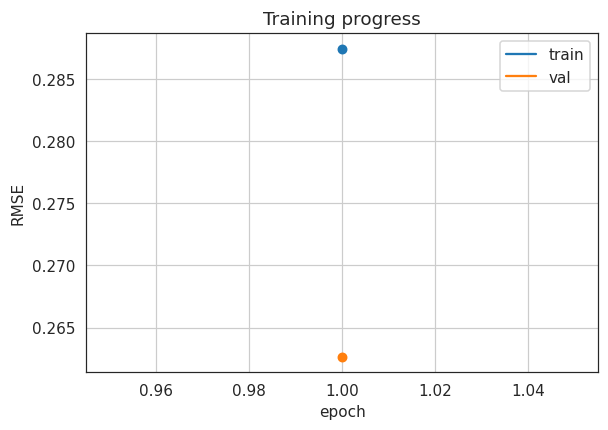

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2874 MAE=0.2246 R2=0.0173 | "B": Acc=0.5173 Prec=0.2653 Rec=0.4515 F1=0.3343 AUROC=0.4950
VALID→ "R": RMSE=0.2626 MAE=0.1969 R2=0.1399 | "B": Acc=0.3084 Prec=0.2815 Rec=0.9852 F1=0.4379 AUROC=0.6771


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

        
study.optimize(
    objective,
    n_trials = 100,
    n_jobs   = 1,
    callbacks=[live_cb, plots.cleanup_callback],
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
